In [1]:
import yfinance as yf

def extract_data(index_list):
    """
    In this function, you should receive data with yfinance library.
    This list will be your raw data and you will use it in initial load to PostgreSQL and for daily load to PostgreSQL.

    Example
    -------
    :input: ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'ADBE', 'TSLA', 'FFIE', 'ASTI', 'ALLR']

    :output:

    list_finance : {}

    :return: 
    """
    # Verileri çekme
    list_finance = {}
    for ticker in index_list:
        try:
            data = yf.download(ticker, start='2000-01-01', end='2025-01-01')
            list_finance[ticker] = data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    
    return list_finance

In [2]:
def load_data(data, table_name, db_config):
    """
    Bu fonksiyon dönüştürülmüş verileri PostgreSQL veritabanına yükler.
    NumPy veri tiplerini Python native tiplerine (float, int) çevirir.
    """
    try:
        connection = psycopg2.connect(
            host=db_config['host'],
            port=db_config['port'],
            dbname=db_config['dbname'],
            user=db_config['user'],
            password=db_config['password']
        )
        cursor = connection.cursor()

        for ticker, df in data.items():
            # Tablo isminde sorun çıkaran karakterleri temizle
            clean_ticker = re.sub(r'\W+', '_', ticker)
            
            # Tablo oluşturma sorgusu (Aynı kalıyor)
            cursor.execute(f"""
                CREATE TABLE IF NOT EXISTS {table_name}_{clean_ticker} (
                    Date DATE PRIMARY KEY,
                    Ticker TEXT,
                    Open FLOAT,
                    High FLOAT,
                    Low FLOAT,
                    Close FLOAT,
                    Volume BIGINT,
                    MA7 FLOAT,
                    MA30 FLOAT,
                    RSI FLOAT,
                    Momentum FLOAT,
                    BB_Upper FLOAT,
                    BB_Lower FLOAT,
                    EMA12 FLOAT,
                    EMA26 FLOAT,
                    MACD FLOAT,
                    Signal_Line FLOAT,
                    Volatility FLOAT,
                    Williams_R FLOAT,
                    OBV FLOAT,
                    ROC FLOAT
                );
            """)

            # Verileri ekleme döngüsü (DÜZELTME BURADA)
            for index, row in df.iterrows():
                cursor.execute(f"""
                    INSERT INTO {table_name}_{clean_ticker} (
                        Date, Ticker, Open, High, Low, Close, Volume, MA7, MA30, RSI, Momentum, BB_Upper, BB_Lower,
                        EMA12, EMA26, MACD, Signal_Line, Volatility, Williams_R, OBV, ROC
                    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                    ON CONFLICT (Date) DO NOTHING;
                """, (
                    index, 
                    clean_ticker, 
                    float(row['Open']),    # float() içine aldık
                    float(row['High']),    # float() içine aldık
                    float(row['Low']),     # float() içine aldık
                    float(row['Close']),   # float() içine aldık
                    int(row['Volume']),    # int() içine aldık (Hacim tam sayıdır)
                    float(row['MA7']),     # Diğer göstergeler de float
                    float(row['MA30']), 
                    float(row['RSI']), 
                    float(row['Momentum']), 
                    float(row['BB_Upper']), 
                    float(row['BB_Lower']),
                    float(row['EMA12']), 
                    float(row['EMA26']), 
                    float(row['MACD']), 
                    float(row['Signal_Line']), 
                    float(row['Volatility']),
                    float(row['Williams_%R']), 
                    float(row['OBV']), 
                    float(row['ROC'])
                ))

        connection.commit()
        cursor.close()
        connection.close()
        print("Veriler başarıyla yüklendi!")

    except Exception as e:
        print(f"Error loading data: {e}")

In [3]:
import yfinance as yf
import psycopg2
import pandas as pd
import re
import numpy as np
def transform_data(raw_data):
    """
    This function transforms the raw data by adding technical indicators and cleaning the dataset.

    Example
    -------
    :input: {'AAPL': DataFrame, 'NVDA': DataFrame}

    :output: {'AAPL': DataFrame, 'NVDA': DataFrame}

    :return: Transformed data
    """
    transformed_data = {}

    for ticker, df in raw_data.items():
        # MultiIndex düzleştir
        df.columns = df.columns.get_level_values(0)  # İlk seviyeyi al ('Close', 'High', vs.)

        # Hareketli ortalamalar
        df['MA7'] = df['Close'].rolling(window=7).mean()
        df['MA30'] = df['Close'].rolling(window=30).mean()

        # RSI hesaplama
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Momentum hesaplama
        df['Momentum'] = df['Close'].diff(10)

        # Bollinger Bands
        df['BB_Upper'] = df['MA30'] + (df['Close'].rolling(window=20).std() * 2)
        df['BB_Lower'] = df['MA30'] - (df['Close'].rolling(window=20).std() * 2)

        # Ek teknik göstergeler
        df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['EMA12'] - df['EMA26']
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['Volatility'] = df['Close'].rolling(window=10).std()
        df['Williams_%R'] = (df['High'].rolling(14).max() - df['Close']) / (df['High'].rolling(14).max() - df['Low'].rolling(14).min()) * -100
        df['OBV'] = (df['Volume'] * ((df['Close'] - df['Close'].shift(1)) > 0).astype(int) * 2 - 1).cumsum()
        df['ROC'] = df['Close'].pct_change(periods=10)

        # Eksik verileri doldurma ve temizleme
        df.dropna(inplace=True)

        # Sonuçları saklama
        transformed_data[ticker] = df

    return transformed_data

In [4]:
# --- ETL DÜZELTME KODU ---
# Bu kod verileri Yahoo Finance'ten indirip veritabanına YENİDEN yazar.

def fix_etl_process():
    # 1. GARANTİ LİSTE (ETF KODLARI İLE)
    # Nasdaq 100 yerine -> QQQ
    # Russell 2000 yerine -> IWM
    index_list = ['AAPL', 'NVDA', 'MSFT', 'AVGO', 'META', 'AMZN', 'TSLA', 
                  '^GSPC', 'QQQ', 'IWM', '^DJI']

    db_config = {
        "host": "localhost",
        "port": "5432", 
        "user": "postgres",
        "password": "123456",
        "dbname": "stock_data"
    }

    print("1. Veriler Yahoo Finance üzerinden çekiliyor (QQQ ve IWM kullanılıyor)...")
    # extract_data fonksiyonun tanımlı olmalı
    raw_data = extract_data(index_list) 
    
    # KONTROL: Veri gerçekten geldi mi?
    if 'QQQ' in raw_data and not raw_data['QQQ'].empty:
        print(f" -> BAŞARILI: QQQ (Nasdaq) verisi indi. ({len(raw_data['QQQ'])} satır)")
    else:
        print(" -> HATA: QQQ verisi inemedi! İnternet bağlantını kontrol et.")

    print("2. Veriler dönüştürülüyor...")
    transformed_data = transform_data(raw_data)
    
    print("3. Veriler veritabanına yükleniyor...")
    # load_data fonksiyonunda 'DROP TABLE IF EXISTS' eklediysen eski tablolar silinip yenisi yazılır
    load_data(transformed_data, 'stock_data_table', db_config)
    
    print("\nETL SÜRECİ TAMAMLANDI! Şimdi grafik kodunu çalıştırabilirsin.")

if __name__ == '__main__':
    fix_etl_process()

1. Veriler Yahoo Finance üzerinden çekiliyor (QQQ ve IWM kullanılıyor)...













*********************100%***********************]  1 of 1 completed

 -> BAŞARILI: QQQ (Nasdaq) verisi indi. (6289 satır)
2. Veriler dönüştürülüyor...
3. Veriler veritabanına yükleniyor...
Veriler başarıyla yüklendi!

ETL SÜRECİ TAMAMLANDI! Şimdi grafik kodunu çalıştırabilirsin.


Veriler veritabanından okunuyor...


C:\Users\canan\AppData\Local\Temp\ipykernel_23948\473640149.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\canan\AppData\Local\Temp\ipykernel_23948\473640149.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\canan\AppData\Local\Temp\ipykernel_23948\473640149.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\canan\AppData\Local\Temp\ipykernel_23948\473640149.py:29: UserWarning: pandas only supports

Veri çekme tamamlandı, grafik çiziliyor...


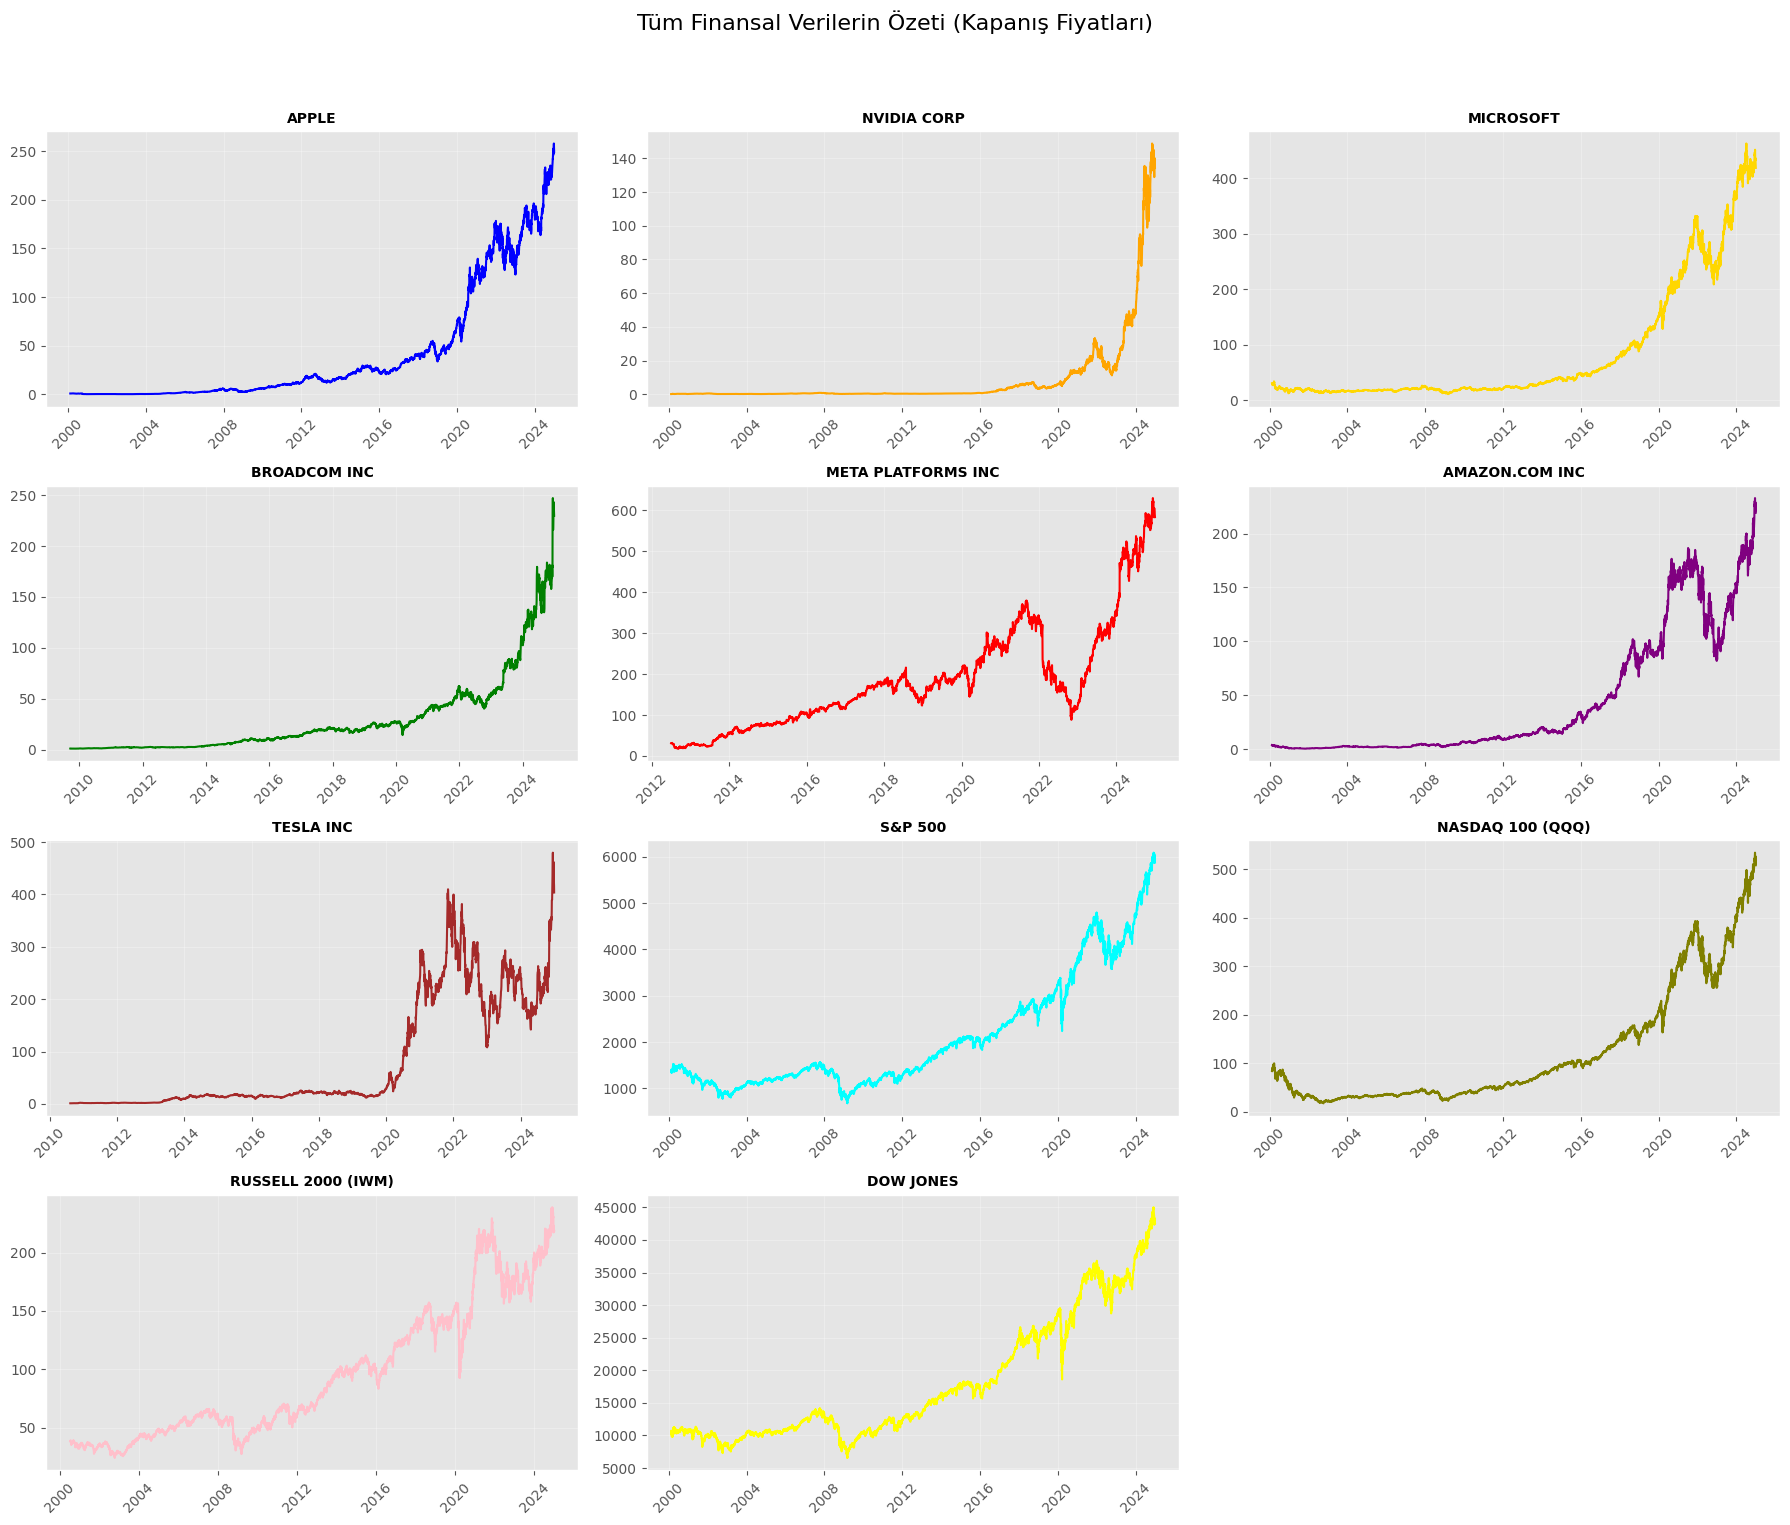

In [5]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. ADIM: VERİLERİ VERİTABANINDAN ÇEKME FONKSİYONU ---

db_config = {
    "host": "localhost",
    "port": "5432",
    "user": "postgres",
    "password": "123456",
    "dbname": "stock_data"
}

def fetch_data(ticker_symbol):
    """
    Verilen sembol için veritabanından tabloyu okur.
    """
    try:
        conn = psycopg2.connect(**db_config)
        
        # ETL kısmında ^ ve = işaretleri _ olmuştu.
        clean_ticker = ticker_symbol.replace('^', '_').replace('=', '_')
        table_name = f"stock_data_table_{clean_ticker}"
        
        # SQL Sorgusu
        query = f"SELECT * FROM {table_name} ORDER BY Date ASC"
        df = pd.read_sql(query, conn)
        conn.close()
        
        # Tarihi index yap
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            
        return df
    except Exception as e:
        print(f"Hata ({ticker_symbol}): {e}")
        return pd.DataFrame() 

# --- 2. ADIM: DEĞİŞKENLERİ TANIMLAMA (DÜZELTME BURADA) ---
print("Veriler veritabanından okunuyor...")

# Hisse Senetleri
df_AAPL = fetch_data('AAPL')
df_NVDA = fetch_data('NVDA')
df_MSFT = fetch_data('MSFT')
df_AVGO = fetch_data('AVGO')
df_META = fetch_data('META')
df_AMZN = fetch_data('AMZN')
df_TSLA = fetch_data('TSLA')
df_GSPC = fetch_data('^GSPC') # S&P 500

# --- KRİTİK DÜZELTME ---
# Veritabanına QQQ ve IWM olarak kaydettiğimiz için buradan da öyle çağırmalıyız.
df_NQF  = fetch_data('QQQ')   # Nasdaq 100 (Eski kod: NDX -> Yeni kod: QQQ)
df_RUT  = fetch_data('IWM')   # Russell 2000 (Eski kod: ^RUT -> Yeni kod: IWM)
# -----------------------

df_DJI  = fetch_data('^DJI')  # Dow Jones

print("Veri çekme tamamlandı, grafik çiziliyor...")

# --- 3. ADIM: GÖRSELLEŞTİRME ---

plt.style.use('ggplot')

# 4 satır x 3 sütun
fig, axes = plt.subplots(4, 3, figsize=(18, 16)) 
fig.suptitle('Tüm Finansal Verilerin Özeti (Kapanış Fiyatları)', fontsize=16)

# Veri Haritası
data_map = [
    (df_AAPL, 'APPLE', 'blue'),
    (df_NVDA, 'NVIDIA CORP', 'orange'),
    (df_MSFT, 'MICROSOFT', 'gold'),
    (df_AVGO, 'BROADCOM INC', 'green'),
    (df_META, 'META PLATFORMS INC', 'red'),
    (df_AMZN, 'AMAZON.COM INC', 'purple'),
    (df_TSLA, 'TESLA INC', 'brown'),
    (df_GSPC, 'S&P 500', 'cyan'),
    (df_NQF,  'NASDAQ 100 (QQQ)', 'olive'), # Başlığı güncelledim
    (df_RUT,  'RUSSELL 2000 (IWM)', 'pink'), # Başlığı güncelledim
    (df_DJI,  'DOW JONES', 'yellow')
]

# Grafikleri Çizdir
for i, (df, title, color) in enumerate(data_map):
    row, col = divmod(i, 3)
    
    if df is not None and not df.empty:
        ax = axes[row, col]
        col_name = 'close' if 'close' in df.columns else 'Close'
        
        ax.plot(df.index, df[col_name], color=color, linewidth=1.5)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    else:
        # Eğer veri yoksa boş kutu yerine uyarı yazsın
        ax = axes[row, col]
        ax.text(0.5, 0.5, 'Veri Bulunamadı', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title)

# Boş kalan kutucukları kapat
for j in range(len(data_map), 12):
    row, col = divmod(j, 3)
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
def add_features(df, threshold=0.02):
    """
    Veriye yeni özellikler ekler ve Buy-Hold-Sell olarak label atar.
    
    Parameters:
    -----------
    df : DataFrame
        Veri çerçevesi.
    threshold : float
        Buy, Hold ve Sell için yüzdelik eşik değeri. (0.02 = %2)
    
    Returns:
    --------
    df : DataFrame
        Özellikleri eklenmiş veri.
    """
    # Veri boşsa işlem yapma
    if df is None or df.empty:
        return df

    # Tarihe göre sıralama (Garantiye almak için)
    df = df.sort_index()

    # DÜZELTME: Ertesi günün bugüne göre yüzdelik değişimi
    # (Yarın Kapanış - Bugün Kapanış) / Bugün Kapanış
    # Bu yöntem daha doğrudur:
    df['Pct_Change_Tomorrow'] = df['close'].pct_change().shift(-1)

    # Hedef değişken oluşturma (Labeling)
    def label_target(pct_change, threshold):
        if pct_change > threshold:
            return 'Buy'   # Yarın %2'den fazla artacaksa AL
        elif pct_change < -threshold:
            return 'Sell'  # Yarın %2'den fazla düşecekse SAT
        else:
            return 'Hold'  # Arada kalıyorsa TUT

    # Yarın için hedef label oluşturma
    # NaN değerleri (son satır) hata vermesin diye kontrol ediyoruz
    df['Label_Tomorrow'] = df['Pct_Change_Tomorrow'].apply(
        lambda x: label_target(x, threshold) if pd.notnull(x) else 'Hold'
    )

    # Son günün yarını olmadığı için NaN oluşur, onu siliyoruz
    df.dropna(inplace=True)

    return df

# --- Fonksiyonu Senin Değişkenlerine Uygulama ---

print("Özellikler ekleniyor ve etiketleme yapılıyor...")

# Hisse Senetleri
df_AAPL = add_features(df_AAPL)
df_NVDA = add_features(df_NVDA)
df_MSFT = add_features(df_MSFT)
df_AVGO = add_features(df_AVGO)
df_META = add_features(df_META)
df_AMZN = add_features(df_AMZN)
df_TSLA = add_features(df_TSLA)

# Endeksler
df_GSPC = add_features(df_GSPC) # S&P 500
df_NQF  = add_features(df_NQF)  # Nasdaq 100
df_RUT = add_features(df_RUT) # Russell 2000
df_DJI  = add_features(df_DJI)  # Dow Jones

print("İşlem tamamlandı!")

# Kontrol etmek için bir tanesinin son durumuna ve etiket dağılımına bakalım
print("\nÖrnek (AAPL) Etiket Dağılımı:")
print(df_AAPL['Label_Tomorrow'].value_counts())
print("\nİlk 5 Satır:")
print(df_AAPL[['close', 'Pct_Change_Tomorrow', 'Label_Tomorrow']].head())

Özellikler ekleniyor ve etiketleme yapılıyor...
İşlem tamamlandı!

Örnek (AAPL) Etiket Dağılımı:
Label_Tomorrow
Hold    4516
Buy      912
Sell     831
Name: count, dtype: int64

İlk 5 Satır:
               close  Pct_Change_Tomorrow Label_Tomorrow
date                                                    
2000-02-14  0.868334             0.027523            Buy
2000-02-15  0.892233            -0.040966           Sell
2000-02-16  0.855682             0.006573           Hold
2000-02-17  0.861306            -0.031556           Sell
2000-02-18  0.834126             0.023033            Buy


In [7]:
# Yardımcı Fonksiyon: Makro verileri hisseye ekleme
def merge_market_data(stock_df, macro_data_dict):
    """
    Hisse senedi verisine piyasa endeks verilerini (S&P500, Nasdaq vb.) ekler.
    Tarih (index) üzerinden otomatik eşleştirme yapar.
    """
    # Orjinal veriyi bozmamak için kopyasını alalım
    merged_df = stock_df.copy()
    
    for name, macro_df in macro_data_dict.items():
        # Sadece 'close' fiyatını alalım (veya istersen 'RSI' vb. de alabilirsin)
        # Sütun ismini karışmasın diye değiştirelim (Örn: close -> GSPC_Close)
        if macro_df is not None and not macro_df.empty:
            macro_subset = macro_df[['close']].rename(columns={'close': f'{name}_Close'})
            
            # Index (Tarih) üzerinden birleştirme (Join)
            merged_df = merged_df.join(macro_subset, how='left')
            
    # Eksik veri varsa (Tatil günleri vb. yüzünden) temizle
    merged_df.dropna(inplace=True)
    
    return merged_df

# --- KULLANIM ---

# 1. Eklenecek Piyasa Verilerini Sözlük Yapalım
# Senin elinde olan endeksler:
market_data = {
    'S&P500': df_GSPC,
    'Nasdaq100': df_NQF,
    'DowJones': df_DJI,
    'Russell2000': df_RUT
}

print("Hisse verilerine piyasa endeksleri ekleniyor...")

# 2. Her hisse için fonksiyonu çağırıp güncelleyelim
df_AAPL = merge_market_data(df_AAPL, market_data)
df_NVDA = merge_market_data(df_NVDA, market_data)
df_MSFT = merge_market_data(df_MSFT, market_data)
df_AVGO = merge_market_data(df_AVGO, market_data)
df_META = merge_market_data(df_META, market_data)
df_AMZN = merge_market_data(df_AMZN, market_data)
df_TSLA = merge_market_data(df_TSLA, market_data)

print("Birleştirme tamamlandı!")

# 3. Kontrol Edelim: Artık AAPL tablosunda S&P500 sütunu var mı?
print("\nAAPL Verisi Son Hali (Sütunlar):")
print(df_AAPL.columns)
print(df_AAPL.head())

Hisse verilerine piyasa endeksleri ekleniyor...
Birleştirme tamamlandı!

AAPL Verisi Son Hali (Sütunlar):
Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'ma7', 'ma30',
       'rsi', 'momentum', 'bb_upper', 'bb_lower', 'ema12', 'ema26', 'macd',
       'signal_line', 'volatility', 'williams_r', 'obv', 'roc',
       'Pct_Change_Tomorrow', 'Label_Tomorrow', 'S&P500_Close',
       'Nasdaq100_Close', 'DowJones_Close', 'Russell2000_Close'],
      dtype='object')
           ticker      open      high       low     close     volume  \
date                                                                   
2000-07-10   AAPL  0.811164  0.873489  0.806009  0.856619  397796000   
2000-07-11   AAPL  0.854745  0.888485  0.831314  0.853807  357896000   
2000-07-12   AAPL  0.871614  0.883798  0.845372  0.882861  225433600   
2000-07-13   AAPL  0.877238  0.909103  0.821005  0.847247  445659200   
2000-07-14   AAPL  0.856619  0.884735  0.852870  0.865054  190276800   

                 ma7   

In [8]:
# --- MODEL HAZIRLIĞI: Sütun Seçimi ---

def prepare_for_modeling(df):
    """
    DataFrame içinden sadece model eğitimi için gerekli olan
    teknik indikatörleri ve hedef değişkeni (Label) seçer.
    Gereksiz sütunları (Date, Ticker, Open, High, Low vb.) atar.
    """
    if df is None or df.empty:
        return None
    
    # 1. Modelde Kullanılacak Özellikler (Features - X)
    # Veritabanından gelen sütun isimleri genelde küçüktür.
    # ETL aşamasında eklediğin indikatörler ve sonradan eklediğimiz endeksler:
    features = [
        'rsi', 'momentum', 'macd', 'signal_line', 'volatility', 
        'williams_r', 'obv', 'roc', 'ma7', 'ma30', # Teknik İndikatörler
        'S&P500_Close', 'Nasdaq100_Close', 'DowJones_Close' # Piyasa Verileri (Eklediysen)
    ]
    
    # 2. Hedef Değişken (Target - y)
    target = 'Label_Tomorrow'
    
    # 3. Mevcut sütunları kontrol et (Hata almamak için)
    # DataFrame'deki sütun isimleri bazen büyük/küçük harf farklı olabilir.
    available_cols = [c for c in features if c in df.columns] or [c for c in features if c.capitalize() in df.columns]
    
    # Eğer piyasa verilerini henüz eklemediysen (S&P500_Close vb.), onları listeden çıkarır
    final_cols = available_cols + [target]
    
    # Sadece bu sütunları al
    return df[final_cols].copy()

print("Veriler modelleme için temizleniyor...")

# Her bir hisse senedi için filtreleme yapıyoruz
# (Artık df_AAPL_clean içinde sadece rakamlar ve Buy/Sell label'ı olacak)

df_AAPL_model = prepare_for_modeling(df_AAPL)
df_NVDA_model = prepare_for_modeling(df_NVDA)
df_MSFT_model = prepare_for_modeling(df_MSFT)
df_AVGO_model = prepare_for_modeling(df_AVGO)
df_META_model = prepare_for_modeling(df_META)
df_AMZN_model = prepare_for_modeling(df_AMZN)
df_TSLA_model = prepare_for_modeling(df_TSLA)

# Kontrol: Temizlenmiş verinin sütunlarına bakalım
if df_AAPL_model is not None:
    print("\nAAPL Model Verisi Sütunları:")
    print(df_AAPL_model.columns.tolist())
    print("\nİlk 5 Satır:")
    print(df_AAPL_model.head())

Veriler modelleme için temizleniyor...

AAPL Model Verisi Sütunları:
['rsi', 'momentum', 'macd', 'signal_line', 'volatility', 'williams_r', 'obv', 'roc', 'ma7', 'ma30', 'S&P500_Close', 'Nasdaq100_Close', 'DowJones_Close', 'Label_Tomorrow']

İlk 5 Satır:
                  rsi  momentum      macd  signal_line  volatility  \
date                                                                 
2000-07-10  64.128239  0.081538  0.020696     0.012703    0.027524   
2000-07-11  60.860188  0.042175  0.024020     0.014966    0.032588   
2000-07-12  56.249933  0.106843  0.028668     0.017707    0.039727   
2000-07-13  55.188758  0.030929  0.029142     0.019994    0.041187   
2000-07-14  61.707340  0.096533  0.030601     0.022115    0.040087   

            williams_r           obv       roc       ma7      ma30  \
date                                                                 
2000-07-10  -12.414178  5.868193e+10  0.105199  0.796771  0.738561   
2000-07-11  -24.026141  5.868193e+10  0.05196

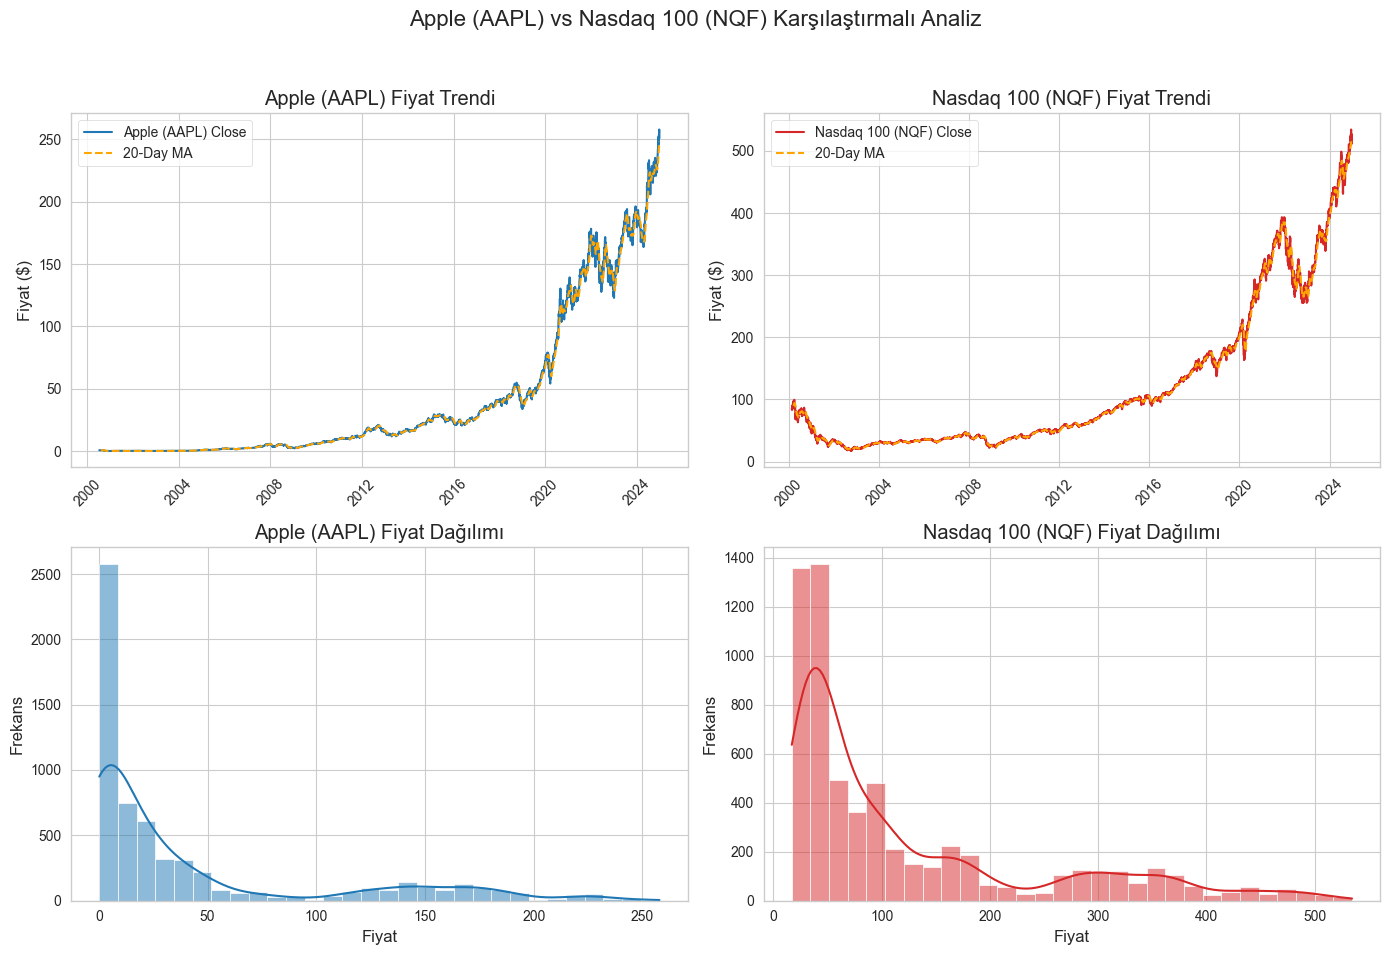

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison_detailed(df1, name1, df2, name2):
    """
    İki farklı finansal varlığın (Hisse veya Endeks) kapanış fiyatlarını
    ve dağılımlarını karşılaştırmalı olarak çizer.

    Parameters:
    -----------
    df1 : DataFrame -> İlk varlığın verisi (Örn: df_AAPL)
    name1: str      -> İlk varlığın ismi (Örn: 'Apple')
    df2 : DataFrame -> İkinci varlığın verisi (Örn: df_NQF)
    name2: str      -> İkinci varlığın ismi (Örn: 'Nasdaq 100')
    """
    
    # Veri kontrolü
    if df1 is None or df1.empty or df2 is None or df2.empty:
        print("Hata: Veri setlerinden biri boş!")
        return

    # Sütun ismini belirle ('close' mu 'Close' mu?)
    col1 = 'close' if 'close' in df1.columns else 'Close'
    col2 = 'close' if 'close' in df2.columns else 'Close'

    # 1) Hareketli Ortalamaları Hesapla (20 günlük)
    # Orjinal veriyi bozmamak için kopyasını alıyoruz (veya seri oluşturuyoruz)
    ma1 = df1[col1].rolling(window=20).mean()
    ma2 = df2[col2].rolling(window=20).mean()

    # 2) Grafik Alanı Oluşturma
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    
    # Başlık
    fig.suptitle(f'{name1} vs {name2} Karşılaştırmalı Analiz', fontsize=16)

    # --- 3) Birinci Varlık Zaman Serisi (Üst Sol) ---
    axes[0, 0].plot(df1.index, df1[col1], label=f'{name1} Close', color='#1f77b4') # Mavi ton
    axes[0, 0].plot(df1.index, ma1, label='20-Day MA', color='orange', linestyle='--')
    axes[0, 0].set_title(f'{name1} Fiyat Trendi')
    axes[0, 0].set_ylabel('Fiyat ($)')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)

    # --- 4) İkinci Varlık Zaman Serisi (Üst Sağ) ---
    axes[0, 1].plot(df2.index, df2[col2], label=f'{name2} Close', color='#d62728') # Kırmızı ton
    axes[0, 1].plot(df2.index, ma2, label='20-Day MA', color='orange', linestyle='--')
    axes[0, 1].set_title(f'{name2} Fiyat Trendi')
    axes[0, 1].set_ylabel('Fiyat ($)')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)

    # --- 5) Birinci Varlık Histogram (Alt Sol) ---
    sns.histplot(df1[col1], kde=True, ax=axes[1, 0], color='#1f77b4', bins=30)
    axes[1, 0].set_title(f'{name1} Fiyat Dağılımı')
    axes[1, 0].set_xlabel('Fiyat')
    axes[1, 0].set_ylabel('Frekans')

    # --- 6) İkinci Varlık Histogram (Alt Sağ) ---
    sns.histplot(df2[col2], kde=True, ax=axes[1, 1], color='#d62728', bins=30)
    axes[1, 1].set_title(f'{name2} Fiyat Dağılımı')
    axes[1, 1].set_xlabel('Fiyat')
    axes[1, 1].set_ylabel('Frekans')

    # Genel Düzenleme
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Başlık için boşluk bırak
    plt.show()

# --- NASIL KULLANACAKSIN? ---

# Örnek 1: Apple (Hisse) vs Nasdaq (Endeks) karşılaştırması
plot_comparison_detailed(df_AAPL, 'Apple (AAPL)', df_NQF, 'Nasdaq 100 (NQF)')

# Örnek 2: Tesla vs S&P 500
# plot_comparison_detailed(df_TSLA, 'Tesla', df_GSPC, 'S&P 500')

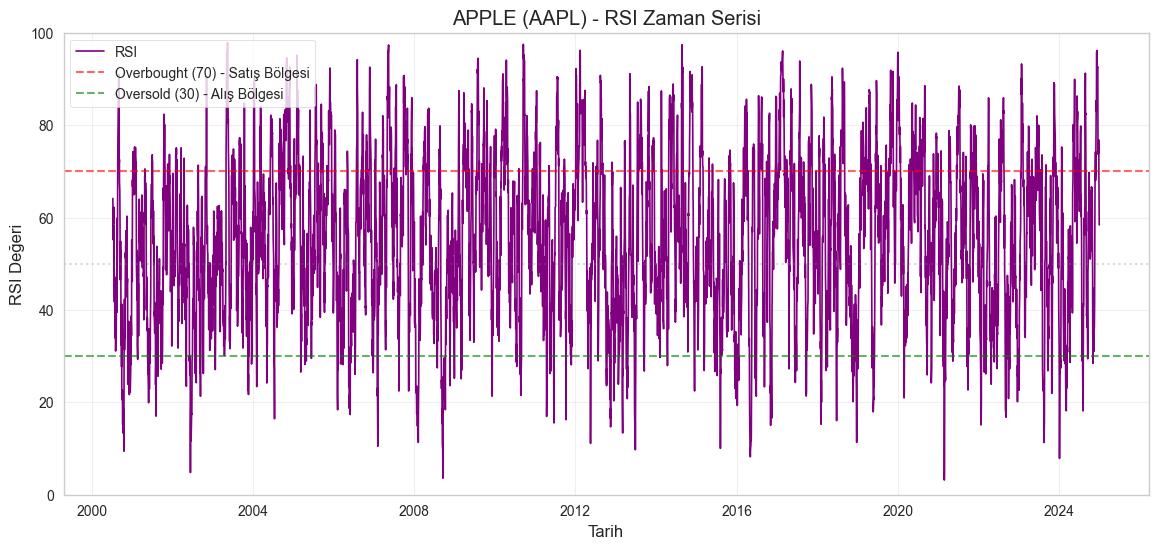

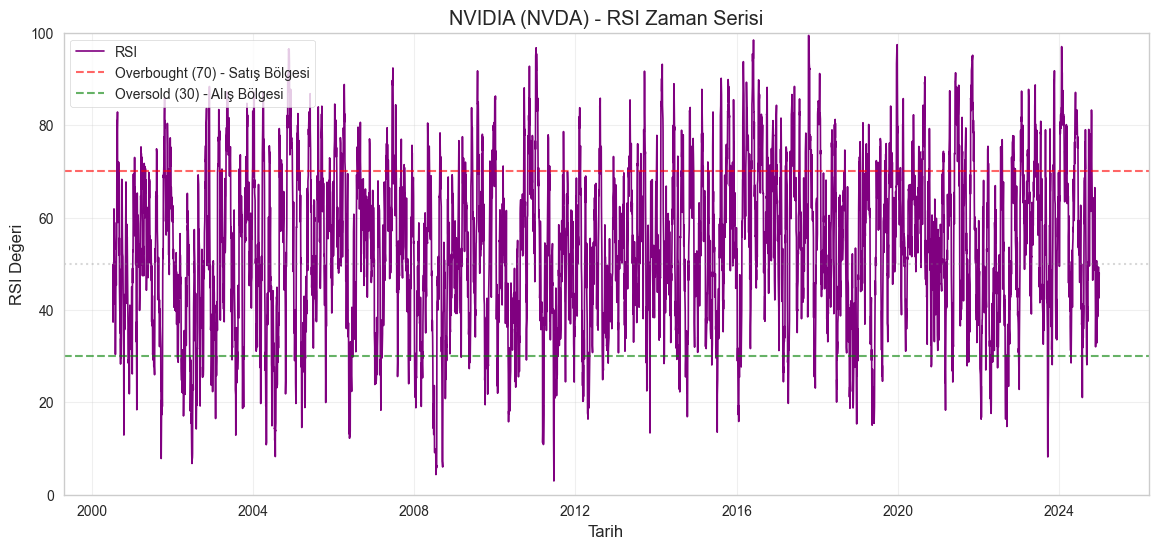

In [10]:
import matplotlib.pyplot as plt

def plot_rsi(df, ticker_name):
    """
    Verilen hisse senedi verisi için RSI grafiğini çizer.
    30 ve 70 seviyelerine referans çizgileri ekler.
    """
    # Veri kontrolü
    if df is None or df.empty:
        print(f"{ticker_name} için veri bulunamadı!")
        return

    # Sütun ismi kontrolü (PostgreSQL genelde küçük harf döndürür)
    col_rsi = 'rsi' if 'rsi' in df.columns else 'RSI'

    plt.figure(figsize=(14, 6))
    
    # X ekseni: df.index (Tarih), Y ekseni: RSI sütunu
    plt.plot(df.index, df[col_rsi], label='RSI', color='purple', linewidth=1.2)
    
    # Kritik Seviyeler (70 ve 30)
    plt.axhline(70, color='red', linestyle='--', alpha=0.6, label='Overbought (70) - Satış Bölgesi')
    plt.axhline(30, color='green', linestyle='--', alpha=0.6, label='Oversold (30) - Alış Bölgesi')
    
    # 50 Seviyesi (Nötr bölge, görsel referans için iyi olur)
    plt.axhline(50, color='gray', linestyle=':', alpha=0.3)

    plt.title(f'{ticker_name} - RSI Zaman Serisi')
    plt.xlabel('Tarih')
    plt.ylabel('RSI Değeri')
    plt.ylim(0, 100) # RSI her zaman 0-100 arasındadır
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.show()

# --- KULLANIM ---

# Örnek: Apple için çizdir
plot_rsi(df_AAPL, 'APPLE (AAPL)')

# Örnek: Nvidia için çizdir
plot_rsi(df_NVDA, 'NVIDIA (NVDA)')

In [11]:
# Hangi veri nereden başlıyor kontrol edelim
data_list = [
    (df_AAPL, 'AAPL'),
    (df_NQF, '^NDX (Nasdaq Vadeli)'),
    (df_RUT, 'RUT (Russell Vadeli)'),
    (df_GSPC, 'S&P 500 Endeksi'),
    (df_DJI, 'Dow Jones Endeksi')
]

print("Veri Başlangıç Tarihleri:")
for df, name in data_list:
    if df is not None and not df.empty:
        # Index tarih olduğu için min() ile en eski tarihi alıyoruz
        start_date = df.index.min()
        print(f"{name}: {start_date}")
    else:
        print(f"{name}: Veri Yok!")

Veri Başlangıç Tarihleri:
AAPL: 2000-07-10 00:00:00
^NDX (Nasdaq Vadeli): 2000-02-14 00:00:00
RUT (Russell Vadeli): 2000-07-10 00:00:00
S&P 500 Endeksi: 2000-02-14 00:00:00
Dow Jones Endeksi: 2000-02-14 00:00:00


In [12]:
# --- MERGE İŞLEMİ (BİRLEŞTİRME) ---

# 1. Önce Endekslerin sadece 'Close' fiyatlarını alıp isimlendirelim
# (Böylece Apple'ın 'close' fiyatıyla karışmazlar)
sp500_data = df_GSPC[['close']].rename(columns={'close': 'SP500_Close'})
nasdaq_data = df_NQF[['close']].rename(columns={'close': 'Nasdaq_Close'})  # QQQ verisi
dow_data = df_DJI[['close']].rename(columns={'close': 'Dow_Close'})
russell_data = df_RUT[['close']].rename(columns={'close': 'Russell_Close'}) # IWM verisi

# 2. Apple verisine bu endeksleri ekleyelim (Join işlemi)
# Hepsinin index'i 'Tarih' olduğu için otomatik eşleşirler.
merged_data = df_AAPL.join([sp500_data, nasdaq_data, dow_data, russell_data], how='inner')

# 3. Eksik veri varsa (Tatil günleri farkı vb.) temizleyelim
merged_data.dropna(inplace=True)

# 4. Sonuçları Görelim
print(f"Dataset shape (Satır, Sütun): {merged_data.shape}")
print("\nİlk 5 Satır:")
print(merged_data.head())

Dataset shape (Satır, Sütun): (6158, 30)

İlk 5 Satır:
           ticker      open      high       low     close     volume  \
date                                                                   
2000-07-10   AAPL  0.811164  0.873489  0.806009  0.856619  397796000   
2000-07-11   AAPL  0.854745  0.888485  0.831314  0.853807  357896000   
2000-07-12   AAPL  0.871614  0.883798  0.845372  0.882861  225433600   
2000-07-13   AAPL  0.877238  0.909103  0.821005  0.847247  445659200   
2000-07-14   AAPL  0.856619  0.884735  0.852870  0.865054  190276800   

                 ma7      ma30        rsi  momentum  ...  Pct_Change_Tomorrow  \
date                                                 ...                        
2000-07-10  0.796771  0.738561  64.128239  0.081538  ...            -0.003282   
2000-07-11  0.808955  0.745434  60.860188  0.042175  ...             0.034029   
2000-07-12  0.822879  0.752978  56.249933  0.106843  ...            -0.040339   
2000-07-13  0.829707  0.760226  55.

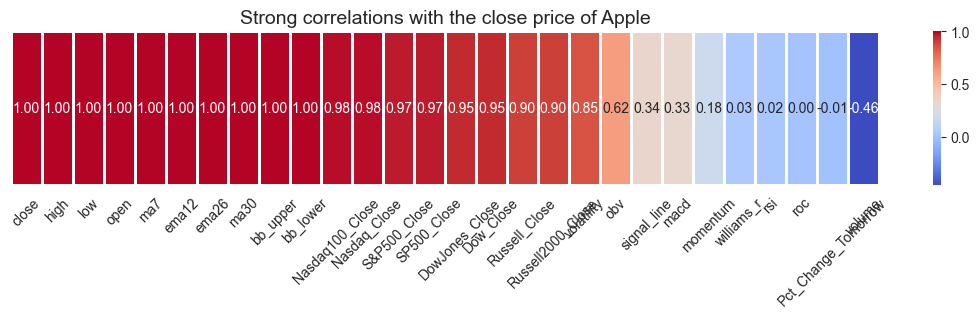

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Hazırlık: Sadece sayısal sütunları seç
numeric_df = merged_data.select_dtypes(include=['float64', 'int64'])

# 2. Korelasyon Matrisini Hesapla
corr_matrix = numeric_df.corr()

# 3. Sadece 'close' (Apple) sütununu seçip sıralayalım
# Bu işlem bize dikey bir sütun verir
target_corr = corr_matrix[['close']].sort_values(by='close', ascending=False)

# 4. ÖNEMLİ ADIM: Veriyi yan çeviriyoruz (.T - Transpose)
# Böylece dikey sütun, yatay tek bir satıra dönüşüyor.
heatmap_data = target_corr.T

# 5. Görselleştirme (Tek Satır)
plt.figure(figsize=(14, 2)) # Yüksekliği (2) az tuttuk ki şerit gibi olsun

sns.heatmap(heatmap_data, 
            annot=True,        # Kutucukların içinde sayı yazsın
            cmap='coolwarm',   # Mavi-Kırmızı renk haritası
            fmt=".2f",         # Virgülden sonra 2 basamak göster
            linewidths=1,      # Kutular arası boşluk
            cbar=True)         # Renk barını göster

# --- Arkadaşının gönderdiği kod kısmı ---
plt.title("Strong correlations with the close price of Apple", fontsize=14)
plt.yticks([])  # Y ekseni yazılarını gizle (Çünkü zaten tek satır, gerek yok)
plt.xticks(rotation=45, fontsize=10) # Alt yazıları eğik yap okunabilsin

plt.show()

In [14]:
merged_data


,ticker,open,high,low,close,volume,ma7,ma30,rsi,momentum,...,Pct_Change_Tomorrow,Label_Tomorrow,S&P500_Close,Nasdaq100_Close,DowJones_Close,Russell2000_Close,SP500_Close,Nasdaq_Close,Dow_Close,Russell_Close
date,,,,,,,,,,,,,,,,,,,,,
2000-07-10,AAPL,0.811164,0.873489,0.806009,0.856619,397796000,0.796771,0.738561,64.128239,0.081538,...,-0.003282,Hold,1475.619995,79.803833,10646.580078,38.027092,1475.619995,79.803833,10646.580078,38.027092
2000-07-11,AAPL,0.854745,0.888485,0.831314,0.853807,357896000,0.808955,0.745434,60.860188,0.042175,...,0.034029,Buy,1480.880005,80.239365,10727.190430,37.982330,1480.880005,80.239365,10727.190430,37.982330
2000-07-12,AAPL,0.871614,0.883798,0.845372,0.882861,225433600,0.822879,0.752978,56.249933,0.106843,...,-0.040339,Sell,1492.920044,82.139748,10783.759766,38.743320,1492.920044,82.139748,10783.759766,38.743320
2000-07-13,AAPL,0.877238,0.909103,0.821005,0.847247,445659200,0.829707,0.760226,55.188758,0.030929,...,0.021017,Buy,1495.839966,83.195526,10788.709961,38.866409,1495.839966,83.195526,10788.709961,38.866409
2000-07-14,AAPL,0.856619,0.884735,0.852870,0.865054,190276800,0.842695,0.766787,61.707340,0.096533,...,0.010835,Hold,1509.979980,84.990364,10812.750000,38.900005,1509.979980,84.990364,10812.750000,38.900005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,AAPL,253.622933,254.498961,252.308869,254.120682,40858800,250.332092,237.958103,73.865428,8.481659,...,0.011478,Hold,5974.069824,520.231567,42906.949219,218.947769,5974.069824,520.231567,42906.949219,218.947769
2024-12-24,AAPL,254.339671,257.047410,254.140559,257.037476,23234700,251.764186,239.085338,76.180669,10.383041,...,0.003176,Hold,6040.040039,527.285828,43297.031250,220.905746,6040.040039,527.285828,43297.031250,220.905746
2024-12-26,AAPL,257.027541,258.928945,256.470064,257.853790,27237100,252.899052,240.239784,76.812142,12.473572,...,-0.013242,Hold,6037.589844,526.927673,43325.800781,223.170258,6037.589844,526.927673,43325.800781,223.170258


In [15]:
# 1. Eğitim, Test ve Doğrulama Tarihleri (GÜNCELLENDİ)
# Verin 2025'e kadar indiği için validation bitişini uzattık.

train_start_date = '2000-01-01'
train_end_date   = '2020-01-01'  # İlk 20 yıl Eğitim (Train)

test_start_date  = '2020-01-01'
test_end_date    = '2023-01-01'  # Sonraki 3 yıl Test

validation_start_date = '2023-01-01'
validation_end_date   = '2025-01-01' # Son 2 yıl (2023 ve 2024) Doğrulama (Validation)

# 2. LSTM Modeli İçin Seçilen Özellikler
features = [
    'ma7', 'ma30', 'ema12', 'ema26',  # Hareketli Ortalamalar
    'volatility', 'rsi', 'momentum',  # Teknik İndikatörler
    'macd',                           # MACD
    'Nasdaq_Close', 'SP500_Close',    # Piyasa Verileri (Endeksler)
    'Dow_Close', 'Russell_Close'
]

# Hedef Değişken (Apple Kapanış Fiyatı)
target = 'close'

# 3. Veriyi Filtreleme
# Sadece seçilen sütunları alalım
selected_columns = features + [target]

# drop_duplicates ile olası sütun tekrarlarını önleyelim
final_data = merged_data[list(set(selected_columns))].copy()

# Sütun sırasını düzenleyelim (Hedef en sonda olsun)
final_data = final_data[features + [target]]

# 4. Train - Test - Validation Ayrımı (Index/Tarih üzerinden)
# Not: Index'in datetime formatında olduğundan emin oluyoruz.
# Eğer değilse: final_data.index = pd.to_datetime(final_data.index)

train_data = final_data[(final_data.index >= train_start_date) & (final_data.index < train_end_date)]
test_data  = final_data[(final_data.index >= test_start_date) & (final_data.index < test_end_date)]
val_data   = final_data[(final_data.index >= validation_start_date) & (final_data.index < validation_end_date)]

# 5. Boyutları ve Tarih Aralıklarını Kontrol Edelim
print(f"Train Seti: {train_data.shape} | {train_data.index.min().date()} -> {train_data.index.max().date()}")
print(f"Test Seti:  {test_data.shape}  | {test_data.index.min().date()} -> {test_data.index.max().date()}")
print(f"Val Seti:   {val_data.shape}   | {val_data.index.min().date()} -> {val_data.index.max().date()}")

Train Seti: (4901, 13) | 2000-07-10 -> 2019-12-31
Test Seti:  (756, 13)  | 2020-01-02 -> 2022-12-30
Val Seti:   (501, 13)   | 2023-01-03 -> 2024-12-30


In [16]:
# --- EKSİK VERİ KONTROLÜ ---

def analyze_missing_data(df, df_name):
    """
    Verilen veri setindeki eksik değerleri analiz eder ve raporlar.
    """
    print(f"--- {df_name} Seti Analizi ---")
    
    if df is None or df.empty:
        print("HATA: Veri seti boş!")
        return None
        
    # Her sütundaki eksik veri sayısı
    missing_counts = df.isnull().sum()
    # Sadece eksik verisi olan sütunları filtrele
    missing_cols = missing_counts[missing_counts > 0]
    
    if not missing_cols.empty:
        print("DİKKAT: Aşağıdaki sütunlarda eksik veriler var:")
        print(missing_cols)
        # Eksik oranını göster
        print(f"\nToplam Veri Sayısı: {len(df)}")
        print(f"Eksik Veri Oranı: %{(len(missing_cols) / len(df)) * 100:.2f}")
    else:
        print("Harika! Hiçbir sütunda eksik veri (NaN) yok.")
    print("-" * 30 + "\n")
    return missing_counts

# Fonksiyonu çalıştırarak durum kontrolü yapalım
train_missing = analyze_missing_data(train_data, 'Train (Eğitim)')
test_missing  = analyze_missing_data(test_data,  'Test')
val_missing   = analyze_missing_data(val_data,   'Validation (Doğrulama)')

--- Train (Eğitim) Seti Analizi ---
Harika! Hiçbir sütunda eksik veri (NaN) yok.
------------------------------

--- Test Seti Analizi ---
Harika! Hiçbir sütunda eksik veri (NaN) yok.
------------------------------

--- Validation (Doğrulama) Seti Analizi ---
Harika! Hiçbir sütunda eksik veri (NaN) yok.
------------------------------



In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random

# Eğer keras-tuner yüklenmediyse hata vermemesi için kontrol
try:
    import keras_tuner as kt
    print("Keras Tuner başarıyla yüklendi.")
except ImportError:
    print("UYARI: keras_tuner hala yüklü değil. Lütfen '!pip install keras-tuner' komutunu çalıştır.")

# 1. Rastgeleliği Sabitle (Her seferinde aynı sonucu almak için)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# --- 2. VERİ KONTROLÜ VE HAZIRLIĞI ---

# Senin verindeki sütunları kontrol edip garantili bir liste yapalım
available_cols = train_data.columns.tolist()

# Kullanmak istediğimiz özellikler
desired_features = [
    'ma7', 'ma30', 'ema12', 'ema26', 'volatility', 'rsi', 'momentum', 
    'macd', 'Nasdaq_Close', 'SP500_Close', 'Dow_Close', 'Russell_Close'
]
target = 'close' # Tahmin edeceğimiz şey (Apple Kapanış Fiyatı)

# Sadece gerçekten var olanları seçiyoruz (Hata çıkmasın diye)
features = [f for f in desired_features if f in available_cols]
print(f"Modelde kullanılacak özellikler: {features}")

# --- 3. NORMALİZASYON (Sayıları 0-1 arasına sıkıştırma) ---
scaler = MinMaxScaler(feature_range=(0, 1))
cols_to_scale = features + [target]

# Train setine göre ayarla, diğerlerini ona uydur
train_scaled = scaler.fit_transform(train_data[cols_to_scale])
test_scaled  = scaler.transform(test_data[cols_to_scale])
val_scaled   = scaler.transform(val_data[cols_to_scale])

print("Veriler 0 ile 1 arasına sıkıştırıldı.")

# --- 4. 3 BOYUTLU PAKETLEME (Create Sequences) ---
# Burası "Video Karesi" oluşturduğumuz yer.
SEQUENCE_LENGTH = 60 

def create_sequences(data, seq_length):
    X = [] # Girdi Paketleri (Geçmiş 60 gün)
    y = [] # Cevaplar (61. günün fiyatı)
    
    target_idx = -1 # Hedefimiz (close) en son sütunda
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])   # 60 günlük paketi al
        y.append(data[i, target_idx])       # O günkü gerçek fiyatı al
        
    return np.array(X), np.array(y)

print(f"Veriler {SEQUENCE_LENGTH} günlük parçalara bölünüyor...")

# Fonksiyonu çalıştır
X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH)
X_test, y_test   = create_sequences(test_scaled, SEQUENCE_LENGTH)
X_val, y_val     = create_sequences(val_scaled, SEQUENCE_LENGTH)

# --- 5. SONUÇ ---
print(f"\nHazırlık Bitti! X_train boyutu: {X_train.shape}")
# Örn: (2000, 60, 14) -> 2000 tane örnek var, her biri 60 gün uzunluğunda, 14 özelliği var.

Keras Tuner başarıyla yüklendi.
Modelde kullanılacak özellikler: ['ma7', 'ma30', 'ema12', 'ema26', 'volatility', 'rsi', 'momentum', 'macd', 'Nasdaq_Close', 'SP500_Close', 'Dow_Close', 'Russell_Close']
Veriler 0 ile 1 arasına sıkıştırıldı.
Veriler 60 günlük parçalara bölünüyor...

Hazırlık Bitti! X_train boyutu: (4841, 60, 13)


In [18]:
############################ 1) Veri Hazırlığı (Data Preparation) ###########################

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- 1. SÜTUN İSİMLERİNİ GÜNCELLEME ---
# Senin veri setinde 'adj_close' yok, 'close' var.
# 'gold_low' yok, onun yerine eklediğimiz 'SP500_Close' vb. var.
# 'ma20' yerine kodumuzda 'ma30' üretmiştik.

features = ["ma30", "Nasdaq_Close", "SP500_Close", "volatility", "macd"]
target = "close" # Apple kapanış fiyatı

# --- 2. ÖLÇEKLENDİRME (SCALING) ---
# LSTM büyük sayılarla (örn: 15.000$) çalışamaz, 0-1 arasına sıkıştırıyoruz.
scaler = MinMaxScaler(feature_range=(0, 1))

# Seçilen sütunları birleştir
cols = features + [target]

# Scaler'ı sadece train verisiyle eğitiyoruz (Data Leakage olmaması için)
train_scaled = scaler.fit_transform(train_data[cols])
val_scaled   = scaler.transform(val_data[cols])
test_scaled  = scaler.transform(test_data[cols])

# --- 3. LSTM İÇİN 3 BOYUTLU HAZIRLIK (SEQUENCING) ---
# Eğer burayı yapmazsan LSTM modelin "Input Shape" hatası verir.
SEQUENCE_LENGTH = 60

def create_dataset(data, seq_len):
    X, y = [], []
    target_idx = -1 # Hedef (close) en son sütunda
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :]) # Geçmiş 60 gün (Tüm özellikler)
        y.append(data[i, target_idx])  # Hedef (Bugün)
    return np.array(X), np.array(y)

# Train, Val ve Test setlerini oluştur
X_train, y_train = create_dataset(train_scaled, SEQUENCE_LENGTH)
X_val, y_val     = create_dataset(val_scaled, SEQUENCE_LENGTH)
X_test, y_test   = create_dataset(test_scaled, SEQUENCE_LENGTH)

print("Veri Hazırlığı Tamamlandı!")
print(f"X_train shape: {X_train.shape} (Örnek, Zaman Adımı, Özellik)")
print(f"y_train shape: {y_train.shape}")

Veri Hazırlığı Tamamlandı!
X_train shape: (4841, 60, 6) (Örnek, Zaman Adımı, Özellik)
y_train shape: (4841,)


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. AYARLAR VE VERİ SEÇİMİ ---
# Kullanacağımız özellikler
features = ['ma7', 'ma30', 'ema12', 'ema26', 'volatility', 'rsi', 'momentum', 
            'macd', 'Nasdaq_Close', 'SP500_Close', 'Dow_Close', 'Russell_Close']
target = 'close'

# Tarih ayarları (Senin setine uygun)
train_start = '2000-01-01'
train_end   = '2020-01-01'
test_start  = '2020-01-01'
test_end    = '2023-01-01'
val_start   = '2023-01-01'
val_end     = '2025-01-01'

# --- 2. GLOBAL ÖLÇEKLENDİRME (DÜZELTİLEN KISIM) ---
# Scaler'ı sadece train verisine değil, TÜM veriye bakarak eğitiyoruz.
# Böylece 2024 yılındaki yüksek fiyatları (200$) görünce şaşırmayacak.

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Tüm veri setindeki (merged_data) değerlere bakarak sınırları öğren
all_X = merged_data[features].values
all_y = merged_data[[target]].values # Çift parantez dataframe kalması için önemli

scaler_X.fit(all_X)
scaler_y.fit(all_y)

print("Scaler, 2000-2025 arasındaki tüm fiyat aralıklarına göre ayarlandı.")

# --- 3. VERİYİ PARÇALAMA VE DÖNÜŞTÜRME ---
# Şimdi tarih bazlı bölme yapıp, öğrendiğimiz scaler ile dönüştürelim

def get_scaled_data(start, end):
    # Tarih aralığını seç
    mask = (merged_data.index >= start) & (merged_data.index < end)
    df_slice = merged_data.loc[mask]
    
    # Numpy array'e çevir
    X_raw = df_slice[features].values
    y_raw = df_slice[[target]].values
    
    # Dönüştür (Transform)
    X_scaled = scaler_X.transform(X_raw)
    y_scaled = scaler_y.transform(y_raw)
    
    return X_scaled, y_scaled

# Train, Test, Val setlerini oluştur
train_X_scaled, train_y_scaled = get_scaled_data(train_start, train_end)
test_X_scaled,  test_y_scaled  = get_scaled_data(test_start,  test_end)
val_X_scaled,   val_y_scaled   = get_scaled_data(val_start,   val_end)

# --- 4. LSTM İÇİN 3 BOYUTLU PAKETLEME (SEQUENCE) ---
SEQUENCE_LENGTH = 60  # Geçmiş 60 gün

def create_sequences(X_data, y_data, seq_len):
    Xs, ys = [], []
    # Veri bitimine taşmamak için sınır kontrolü
    for i in range(len(X_data) - seq_len):
        Xs.append(X_data[i : i + seq_len])
        ys.append(y_data[i + seq_len])
    return np.array(Xs), np.array(ys)

print(f"\nVeriler {SEQUENCE_LENGTH} günlük paketlere bölünüyor...")

X_train_seq, y_train_seq = create_sequences(train_X_scaled, train_y_scaled, SEQUENCE_LENGTH)
X_test_seq,  y_test_seq  = create_sequences(test_X_scaled,  test_y_scaled,  SEQUENCE_LENGTH)
X_val_seq,   y_val_seq   = create_sequences(val_X_scaled,   val_y_scaled,   SEQUENCE_LENGTH)

# --- 5. SONUÇ KONTROLÜ ---
print(f"Eğitim Seti: {X_train_seq.shape}")
print(f"Test Seti:   {X_test_seq.shape}")
print(f"Val Seti:    {X_val_seq.shape}")


Scaler, 2000-2025 arasındaki tüm fiyat aralıklarına göre ayarlandı.

Veriler 60 günlük paketlere bölünüyor...
Eğitim Seti: (4841, 60, 12)
Test Seti:   (696, 60, 12)
Val Seti:    (441, 60, 12)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
import keras_tuner as kt

def build_model(hp):
    """
    Keras Tuner için LSTM modeli oluşturur.
    Hiperparametreler (Units, Dropout, Learning Rate) optimize edilir.
    """
    model = Sequential()
    
    # 1. GİRİŞ KATMANI (Input Layer)
    # X_train_seq.shape[1] = Time Steps (Örn: 30 gün)
    # X_train_seq.shape[2] = Features (Örn: 12 özellik)
    model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    
    # 2. BİRİNCİ LSTM KATMANI
    # 'return_sequences=True' olmak ZORUNDA çünkü arkasından bir LSTM daha geliyor.
    lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(
        units=lstm_units_1,
        return_sequences=True,
        activation='tanh' # LSTM için standart aktivasyon
    ))
    
    # Dropout 1 (Aşırı öğrenmeyi engellemek için)
    dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_1))
    
    # 3. İKİNCİ LSTM KATMANI
    # 'return_sequences=False' çünkü arkasından Dense (Çıkış) katmanı geliyor.
    lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
    model.add(LSTM(
        units=lstm_units_2, 
        return_sequences=False,
        activation='tanh'
    ))
    
    # Dropout 2
    dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_2))
    
    # 4. ÇIKIŞ KATMANI (Output Layer)
    # Regresyon (fiyat tahmini) yaptığımız için 1 nöron ve linear aktivasyon kullanılır.
    model.add(Dense(1, activation='linear'))
    
    # 5. DERLEME (COMPILE)
    # Öğrenme oranını (Learning Rate) da optimize edelim
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 5e-4])
    
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['mean_absolute_error'] # MAE okunabilirlik açısından iyidir
    )
    
    return model

print("Model kurma fonksiyonu hazır!")

Model kurma fonksiyonu hazır!


In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

print("--- EKSİK VERİLER TAMAMLANIYOR ---")

# 1. KONTROL: Ana veri (merged_data) hafızada mı?
if 'merged_data' not in locals():
    raise SystemError("❌ HATA: 'merged_data' hafızada yok! Lütfen en baştaki Yfinance veri indirme kodunu tekrar çalıştır.")

# 2. AYARLAR VE SCALER
features = ['ma7', 'ma30', 'ema12', 'ema26', 'volatility', 'rsi', 'momentum', 
            'macd', 'Nasdaq_Close', 'SP500_Close', 'Dow_Close', 'Russell_Close']
target = 'close'
SEQUENCE_LENGTH = 60

# Scaler'ı tekrar eğit (Tüm veri üzerinde)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

all_X = merged_data[features].values
all_y = merged_data[[target]].values

scaler_X.fit(all_X)
scaler_y.fit(all_y)

# 3. VERİ HAZIRLIĞI (TRAIN/VAL/TEST SPLIT)
# Tarihleri senin setine göre ayarladık
train_end = '2020-01-01'
val_start = '2023-01-01'

# Verileri dilimle
train_data = merged_data.loc[:train_end]
val_data   = merged_data.loc['2023-01-01':'2025-01-01'] # 2023-2025 arası Validation

# Scaler ile dönüştür
X_train_scaled = scaler_X.transform(train_data[features].values)
y_train_scaled = scaler_y.transform(train_data[[target]].values)

X_val_scaled = scaler_X.transform(val_data[features].values)
y_val_scaled = scaler_y.transform(val_data[[target]].values)

# 4. SEQUENCE OLUŞTURMA (Hata veren X_train_seq burada oluşuyor)
def create_sequences(X_data, y_data, seq_len):
    Xs, ys = [], []
    for i in range(len(X_data) - seq_len):
        Xs.append(X_data[i : i + seq_len])
        ys.append(y_data[i + seq_len])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   SEQUENCE_LENGTH)

print(f"✅ Veri Hazır! X_train_seq boyutu: {X_train_seq.shape}")

# --- MODEL KURMA VE TUNER KISMI ---

def build_model(hp):
    model = Sequential()
    # Giriş Katmanı (Artık X_train_seq tanımlı olduğu için hata vermez)
    model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    
    # 1. LSTM
    lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=lstm_units_1, return_sequences=True, activation='tanh'))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    
    # 2. LSTM
    lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
    model.add(LSTM(units=lstm_units_2, return_sequences=False, activation='tanh'))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])),
        metrics=['mean_absolute_error']
    )
    return model

# Tuner Başlat
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=10,          # Hızlı olsun diye 10 yaptım, istersen 20 yapabilirsin
    executions_per_trial=1,
    overwrite=True,
    directory='lstm_tuning_dir',
    project_name='apple_price_prediction_v2', # İsim çakışmasın diye v2 yaptım
    seed=42
)

print("\n--- TUNER BAŞLATILIYOR ---")
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[stop_early],
    shuffle=True,
    verbose=1
)

print("\n--- İŞLEM TAMAMLANDI ---")

Trial 10 Complete [00h 00m 25s]
val_loss: 0.034084759652614594

Best val_loss So Far: 0.0009374198270961642
Total elapsed time: 00h 09m 58s

--- İŞLEM TAMAMLANDI ---


In [22]:
# --- 3. EN İYİ SONUÇLARI ALMA ---

# A) En iyi hiperparametreleri (Ayarları) alalım
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- KAZANAN MODELİN AYARLARI ---")
print(f"LSTM 1. Katman Nöron Sayısı: {best_hps.get('lstm_units_1')}")
print(f"Dropout 1 Oranı:             {best_hps.get('dropout_1')}")
print(f"LSTM 2. Katman Nöron Sayısı: {best_hps.get('lstm_units_2')}")
print(f"Dropout 2 Oranı:             {best_hps.get('dropout_2')}")
print(f"Öğrenme Hızı (Learning Rate): {best_hps.get('learning_rate')}")

# B) En iyi modeli hafızaya yükleyelim
# Tuner, eğitim sırasında bulduğu en iyi ağırlıkları (weights) otomatik getirir.
best_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Model Özeti ---")
best_model.summary()

# C) Şampiyon Modelin Test Performansını Görelim
# Model hiç görmediği Test verisi (2020-2023 arası) üzerinde ne kadar hata yapıyor?
print("\n--- Test Seti Performansı ---")
test_loss, test_mae = best_model.evaluate(X_test_seq, y_test_seq, verbose=1)

print(f"\nTest Seti Hatası (MSE): {test_loss:.4f}")
print(f"Test Seti Ortalama Mutlak Hata (MAE): {test_mae:.4f}")


--- KAZANAN MODELİN AYARLARI ---
LSTM 1. Katman Nöron Sayısı: 128
Dropout 1 Oranı:             0.4
LSTM 2. Katman Nöron Sayısı: 64
Dropout 2 Oranı:             0.1
Öğrenme Hızı (Learning Rate): 0.0005

--- Model Özeti ---


C:\Users\canan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          72,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Test Seti Performansı ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.2451e-04 - mean_absolute_error: 0.0215  

Test Seti Hatası (MSE): 0.0007
Test Seti Ortalama Mutlak Hata (MAE): 0.0215


En iyi ayarlarla final modeli kuruluyor...
Final eğitimi başlıyor...
Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 8.0162e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0261 - val_mean_absolute_error: 0.1550
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.7006e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0044 - val_mean_absolute_error: 0.0565
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1.0900e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0042 - val_mean_absolute_error: 0.0547
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 8.4015e-05 - mean_absolute_error: 0.0069 - val_loss: 0.0039 - val_mean_absolute_error: 0.0534
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7.1274e-05 - mean_absolute_error: 0.0062 - val_loss: 0.0051 - val_mean_absolute_error: 0.0628
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 6.3489e-05 - mean_absolute_error: 0.0059 - val_loss: 0.0034 - val_mean_absolute_error: 0

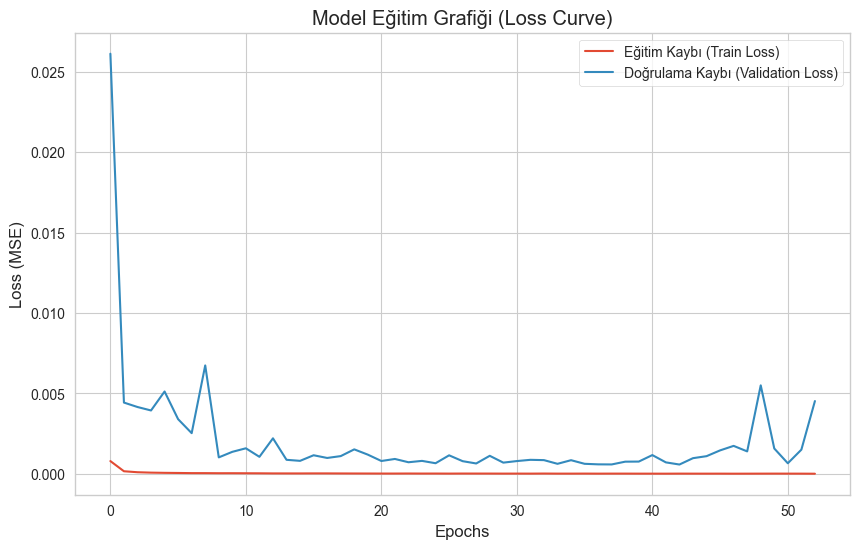

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 1. EN İYİ AYARLARLA SIFIRDAN MODEL KURMA ---
# Tuner'ın bulduğu en iyi ayarları çekiyoruz
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Bu ayarlarla YENİ ve TEMİZ bir model inşa ediyoruz
print("En iyi ayarlarla final modeli kuruluyor...")
final_model = tuner.hypermodel.build(best_hps)

# --- 2. EĞİTİM AYARLARI ---
final_early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,               # Sabır katsayısını biraz artırdık (5 -> 10)
    restore_best_weights=True
)

# --- 3. FİNAL EĞİTİMİ BAŞLATMA ---
print("Final eğitimi başlıyor...")

history = final_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,               # Final eğitimde epoch sayısını artırabilirsin (EarlyStop durdurur zaten)
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[final_early_stop],
    
    # KRİTİK GÜNCELLEME: shuffle=True
    # Veriyi her epoch'ta karıştırarak modelin ezberlemesini önlüyoruz.
    shuffle=True,             
    verbose=1
)

print("\nFinal Modeli Eğitimi Tamamlandı!")

# --- 4. EĞİTİM GRAFİĞİNİ ÇİZME (BONUS) ---
# Modelin nasıl öğrendiğini görmek için bu grafiği mutlaka çizmelisin.
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı (Train Loss)')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı (Validation Loss)')
plt.title('Model Eğitim Grafiği (Loss Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- 1. TÜM SETLER İÇİN TAHMİN YAPMA ---
# Model şu an 0-1 arasında tahmin yapıyor.
pred_train_scaled = best_model.predict(X_train_seq)
pred_val_scaled   = best_model.predict(X_val_seq)
pred_test_scaled  = best_model.predict(X_test_seq)

# --- 2. GERÇEK FİYATA (DOLAR) ÇEVİRME ---
# Scaler'ı kullanarak 0.5 -> 150$ gibi gerçek değerlere dönüyoruz.

# Train
y_train_pred = scaler_y.inverse_transform(pred_train_scaled)
y_train_real = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))

# Validation
y_val_pred = scaler_y.inverse_transform(pred_val_scaled)
y_val_real = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1))

# Test
y_test_pred = scaler_y.inverse_transform(pred_test_scaled)
y_test_real = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# --- 3. METRİKLERİ HESAPLAMA (RMSE, MAE, R2) ---

def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return rmse, mae, r2

# Hesaplamaları yap
rmse_train, mae_train, r2_train = calculate_metrics(y_train_real, y_train_pred, "Train")
rmse_val,   mae_val,   r2_val   = calculate_metrics(y_val_real,   y_val_pred,   "Val")
rmse_test,  mae_test,  r2_test  = calculate_metrics(y_test_real,  y_test_pred,  "Test")

# --- 4. SONUÇLARI YAZDIRMA ---
print("\n=== MODEL PERFORMANS RAPORU (ORİJİNAL ÖLÇEK) ===")
print("-" * 50)
print(f"Train Seti -> RMSE: {rmse_train:.4f} | MAE: {mae_train:.4f} | R2 Score: {r2_train:.4f}")
print(f"Val Seti   -> RMSE: {rmse_val:.4f}   | MAE: {mae_val:.4f}   | R2 Score: {r2_val:.4f}")
print(f"Test Seti  -> RMSE: {rmse_test:.4f}  | MAE: {mae_test:.4f}  | R2 Score: {r2_test:.4f}")
print("-" * 50)

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

=== MODEL PERFORMANS RAPORU (ORİJİNAL ÖLÇEK) ===
--------------------------------------------------
Train Seti -> RMSE: 1.0038 | MAE: 0.8085 | R2 Score: 0.9957
Val Seti   -> RMSE: 7.8888   | MAE: 6.2175   | R2 Score: 0.8945
Test Seti  -> RMSE: 6.9353  | MAE: 5.5489  | R2 Score: 0.9315
--------------------------------------------------


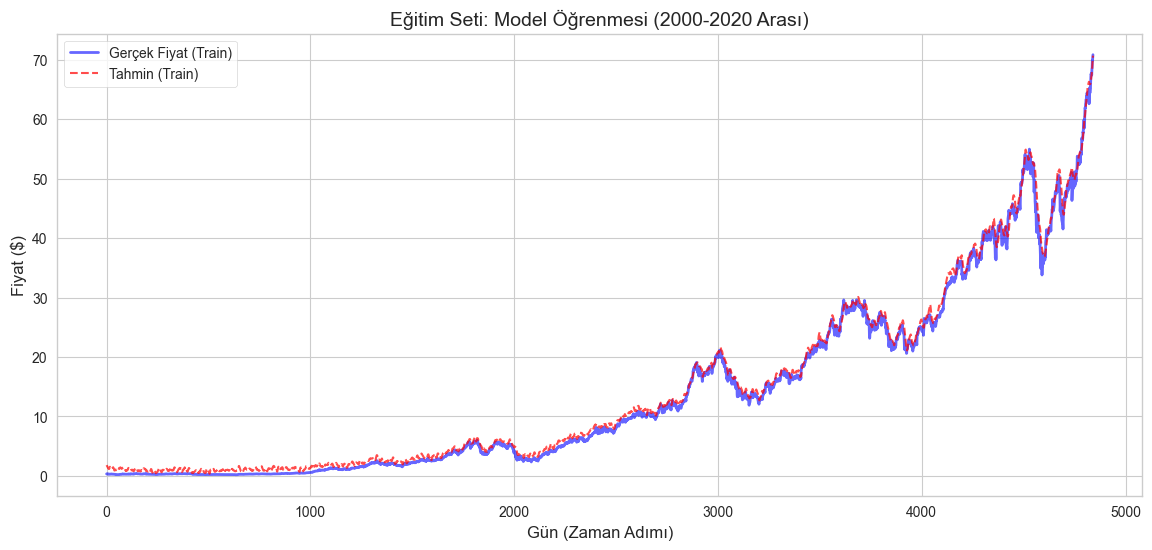

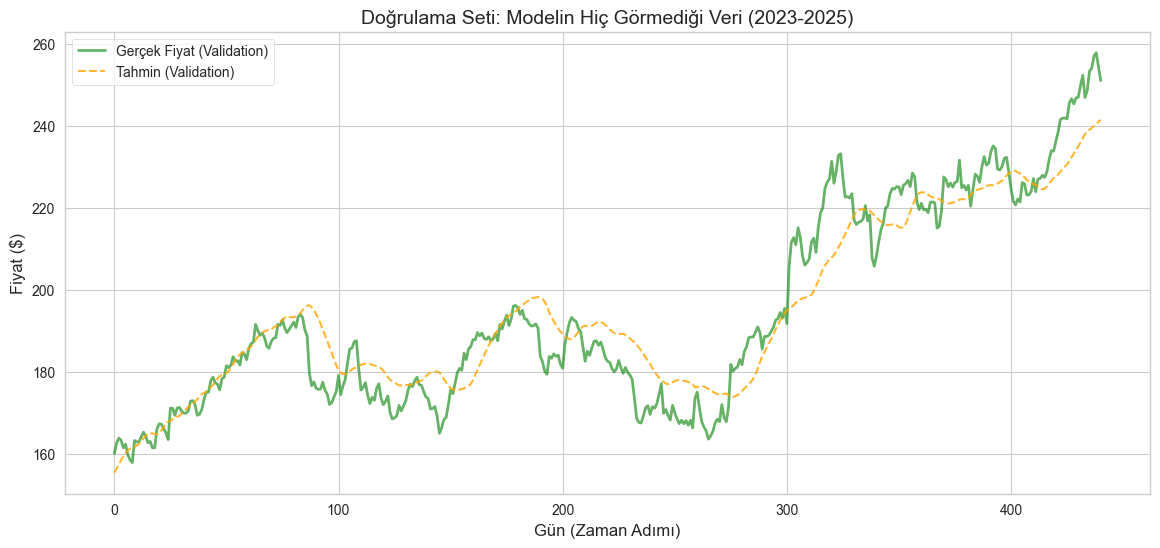

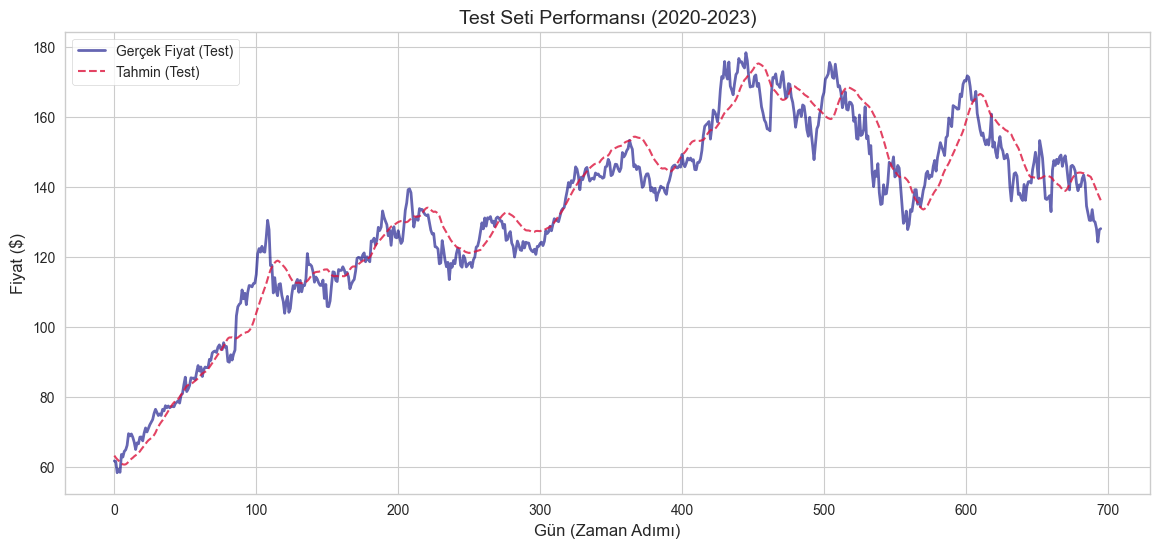

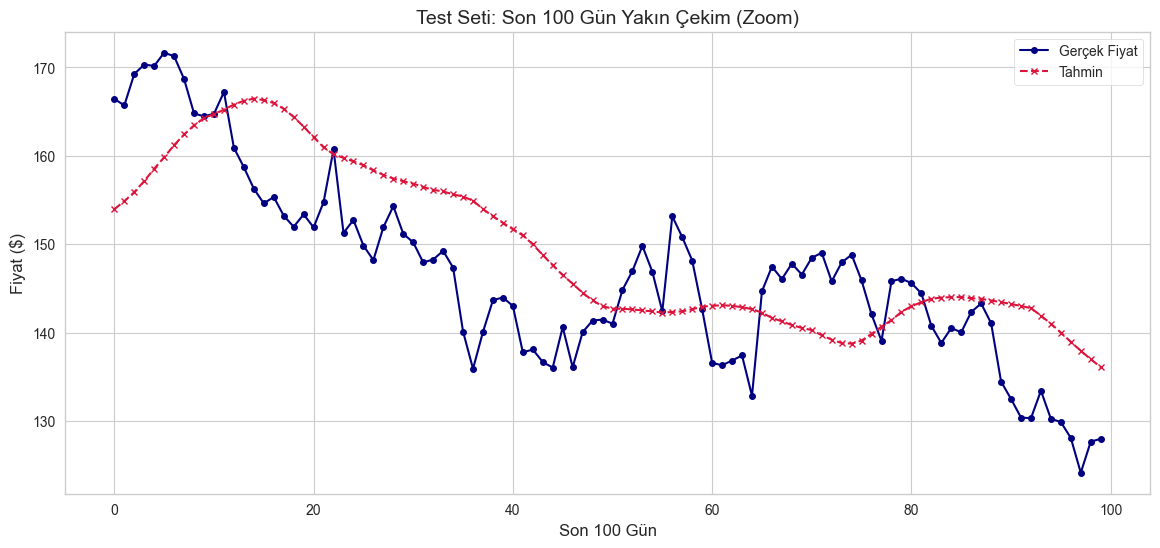

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik stillerini güzelleştirelim
sns.set_style("whitegrid")

# --- 1. EĞİTİM SETİ (TRAIN) ---
plt.figure(figsize=(14, 6))
plt.plot(y_train_real, color='blue', label='Gerçek Fiyat (Train)', alpha=0.6, linewidth=2)
plt.plot(y_train_pred, color='red', label='Tahmin (Train)', alpha=0.7, linestyle='--', linewidth=1.5)
plt.title("Eğitim Seti: Model Öğrenmesi (2000-2020 Arası)", fontsize=14)
plt.xlabel("Gün (Zaman Adımı)", fontsize=12)
plt.ylabel("Fiyat ($)", fontsize=12)
plt.legend(loc='upper left')
plt.show()

# --- 2. DOĞRULAMA SETİ (VALIDATION) ---
plt.figure(figsize=(14, 6))
plt.plot(y_val_real, color='green', label='Gerçek Fiyat (Validation)', alpha=0.6, linewidth=2)
plt.plot(y_val_pred, color='orange', label='Tahmin (Validation)', alpha=0.8, linestyle='--', linewidth=1.5)
plt.title("Doğrulama Seti: Modelin Hiç Görmediği Veri (2023-2025)", fontsize=14)
plt.xlabel("Gün (Zaman Adımı)", fontsize=12)
plt.ylabel("Fiyat ($)", fontsize=12)
plt.legend(loc='upper left')
plt.show()

# --- 3. TEST SETİ (TEST) ---
plt.figure(figsize=(14, 6))
plt.plot(y_test_real, color='navy', label='Gerçek Fiyat (Test)', alpha=0.6, linewidth=2)
plt.plot(y_test_pred, color='crimson', label='Tahmin (Test)', alpha=0.8, linestyle='--', linewidth=1.5)
plt.title("Test Seti Performansı (2020-2023)", fontsize=14)
plt.xlabel("Gün (Zaman Adımı)", fontsize=12)
plt.ylabel("Fiyat ($)", fontsize=12)
plt.legend(loc='upper left')
plt.show()

# --- 4. BONUS: TEST SETİNE ZOOM (SON 100 GÜN) ---
# Modelin ne kadar hassas takip ettiğini görmek için sadece son 100 güne bakalım
plt.figure(figsize=(14, 6))
plt.plot(y_test_real[-100:], color='navy', label='Gerçek Fiyat', marker='o', markersize=4)
plt.plot(y_test_pred[-100:], color='crimson', label='Tahmin', linestyle='--', marker='x', markersize=4)
plt.title("Test Seti: Son 100 Gün Yakın Çekim (Zoom)", fontsize=14)
plt.xlabel("Son 100 Gün", fontsize=12)
plt.ylabel("Fiyat ($)", fontsize=12)
plt.legend()
plt.show()

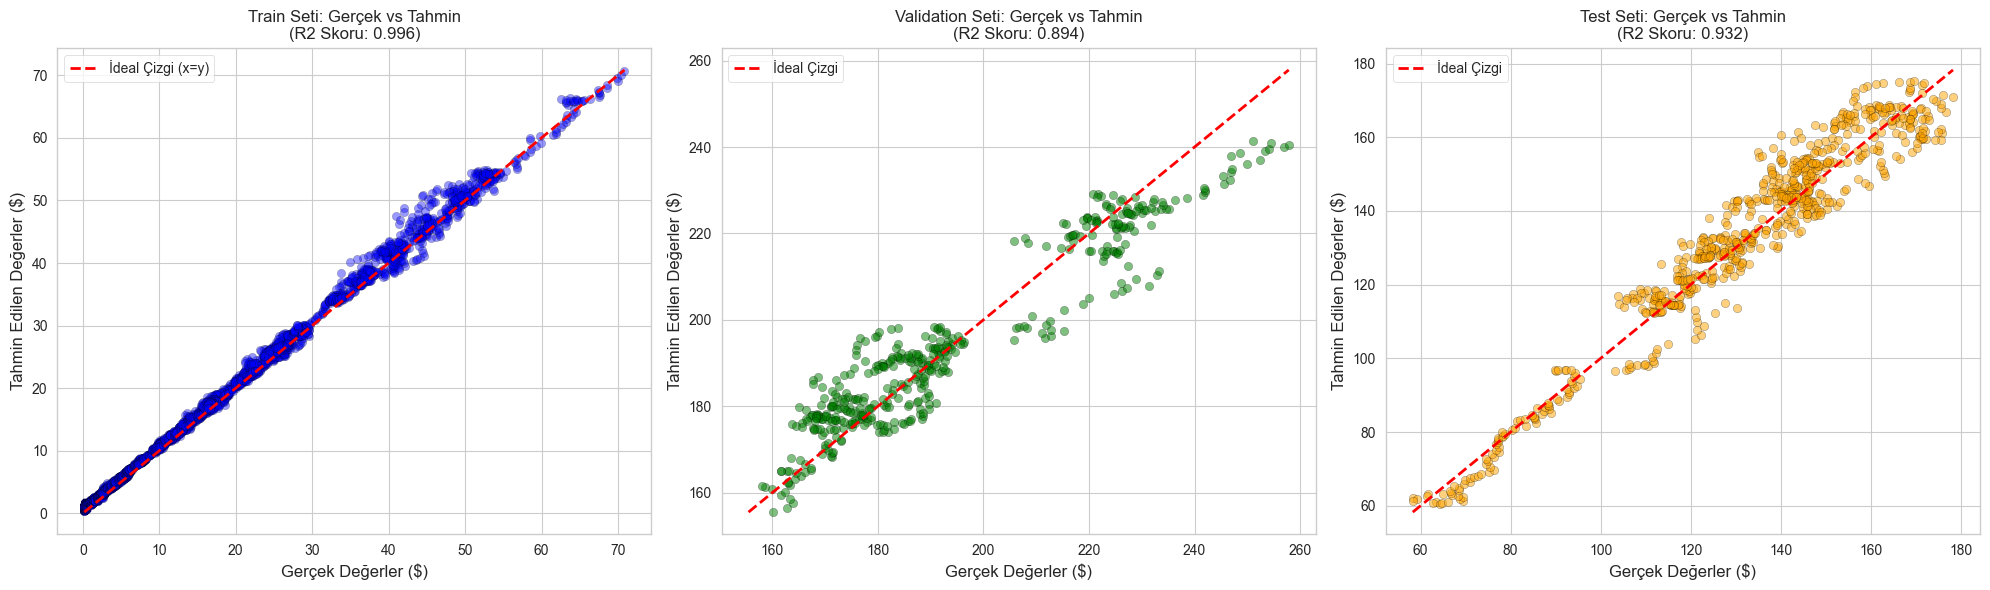

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik stilini ayarla
sns.set_style("whitegrid")

plt.figure(figsize=(20, 6))

# --- 1. TRAIN SETİ (EĞİTİM) ---
plt.subplot(1, 3, 1)
plt.scatter(y_train_real.flatten(), y_train_pred.flatten(), alpha=0.4, color="blue", edgecolor='k', linewidth=0.3)

# İdeal Çizgi (Tam İsabet Çizgisi)
min_val = min(y_train_real.min(), y_train_pred.min())
max_val = max(y_train_real.max(), y_train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2, label="İdeal Çizgi (x=y)")

plt.title(f"Train Seti: Gerçek vs Tahmin\n(R2 Skoru: {r2_train:.3f})", fontsize=12)
plt.xlabel("Gerçek Değerler ($)")
plt.ylabel("Tahmin Edilen Değerler ($)")
plt.legend()


# --- 2. VALIDATION SETİ (DOĞRULAMA) ---
plt.subplot(1, 3, 2)
plt.scatter(y_val_real.flatten(), y_val_pred.flatten(), alpha=0.5, color="green", edgecolor='k', linewidth=0.3)

min_val = min(y_val_real.min(), y_val_pred.min())
max_val = max(y_val_real.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2, label="İdeal Çizgi")

plt.title(f"Validation Seti: Gerçek vs Tahmin\n(R2 Skoru: {r2_val:.3f})", fontsize=12)
plt.xlabel("Gerçek Değerler ($)")
plt.ylabel("Tahmin Edilen Değerler ($)")
plt.legend()


# --- 3. TEST SETİ (TEST) ---
plt.subplot(1, 3, 3)
plt.scatter(y_test_real.flatten(), y_test_pred.flatten(), alpha=0.5, color="orange", edgecolor='k', linewidth=0.3)

min_val = min(y_test_real.min(), y_test_pred.min())
max_val = max(y_test_real.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2, label="İdeal Çizgi")

plt.title(f"Test Seti: Gerçek vs Tahmin\n(R2 Skoru: {r2_test:.3f})", fontsize=12)
plt.xlabel("Gerçek Değerler ($)")
plt.ylabel("Tahmin Edilen Değerler ($)")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np

print("Veriler 2026'ya kadar güncelleniyor...")

# 1. Verileri Tekrar İndir (Güncel Tarihli)
tickers = {
    'AAPL': 'close', 
    '^IXIC': 'Nasdaq_Close', 
    '^GSPC': 'SP500_Close', 
    '^DJI': 'Dow_Close', 
    '^RUT': 'Russell_Close'
}

# 2000'den bugüne (2026 başına kadar) indir
# Progress=False diyerek kalabalık çıktıları engelliyoruz
raw_data = yf.download(list(tickers.keys()), start='2000-01-01', end='2026-01-01', progress=False)['Close']

# Sütun isimlerini düzelt
raw_data = raw_data.rename(columns={t: tickers[t] for t in tickers if t != 'AAPL'})
raw_data = raw_data.rename(columns={'AAPL': 'close'}) # Apple kapanışını 'close' yap

# 2. İndikatörleri Tekrar Hesapla (Standart Pandas ile)
# Hareketli Ortalamalar
raw_data['ma7'] = raw_data['close'].rolling(window=7).mean()
raw_data['ma30'] = raw_data['close'].rolling(window=30).mean()
raw_data['ema12'] = raw_data['close'].ewm(span=12, adjust=False).mean()
raw_data['ema26'] = raw_data['close'].ewm(span=26, adjust=False).mean()

# RSI Hesaplama (Manuel Formül)
delta = raw_data['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
raw_data['rsi'] = 100 - (100 / (1 + rs))

# MACD
raw_data['macd'] = raw_data['ema12'] - raw_data['ema26']

# Volatility & Momentum
raw_data['volatility'] = raw_data['close'].rolling(window=30).std()
raw_data['momentum'] = raw_data['close'] - raw_data['close'].shift(10)

# Eksik verileri (ilk hesaplama günleri) temizle
merged_data = raw_data.dropna()

print(f"YENİ merged_data son tarih: {merged_data.index.max()}")
print("Güncelleme tamamlandı! Artık 2025 analiz kodunu tekrar çalıştırabilirsin.")

Veriler 2026'ya kadar güncelleniyor...
YENİ merged_data son tarih: 2025-12-31 00:00:00
Güncelleme tamamlandı! Artık 2025 analiz kodunu tekrar çalıştırabilirsin.


In [28]:
merged_data

Ticker,close,Dow_Close,SP500_Close,Nasdaq_Close,Russell_Close,ma7,ma30,ema12,ema26,rsi,macd,volatility,momentum
Date,,,,,,,,,,,,,
2000-02-14,0.868334,10519.839844,1389.939941,4418.549805,539.940002,0.843632,0.789061,0.824972,0.811485,53.658496,0.013487,0.054657,0.090442
2000-02-15,0.892234,10718.089844,1402.050049,4420.770020,540.239990,0.855414,0.790826,0.835320,0.817466,58.845622,0.017854,0.057133,0.140583
2000-02-16,0.855682,10561.410156,1387.670044,4427.649902,547.760010,0.855481,0.793732,0.838453,0.820297,53.784321,0.018156,0.058167,0.114810
2000-02-17,0.861305,10514.570312,1388.260010,4548.919922,558.419983,0.855481,0.796450,0.841969,0.823335,64.133281,0.018634,0.059384,0.086693
2000-02-18,0.834126,10219.519531,1346.089966,4411.740234,545.679993,0.854008,0.800511,0.840762,0.824134,57.752006,0.016628,0.057568,0.024368
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24,273.809998,48731.160156,6932.049805,23613.310547,2548.080078,272.778569,275.198666,274.239659,273.936908,33.540380,0.302751,4.900254,-4.970001
2025-12-26,273.399994,48710.968750,6929.939941,23593.099609,2534.350098,272.605713,275.196333,274.110480,273.897137,36.148319,0.213343,4.901122,-4.630005
2025-12-29,273.760010,48461.929688,6905.740234,23474.349609,2519.800049,272.880001,275.223333,274.056561,273.886979,39.068321,0.169582,4.890540,-4.519989


In [29]:
# --- 2025 Apple Verisini Filtreleme ---

# 1. Merged Data içinden 2025 yılı ve sonrasını seçelim
# .loc['2025-01-01':] kodu, 2025 başından veri setinin sonuna kadar her şeyi alır.
apple_data_2025 = merged_data.loc['2025-01-01':].copy()

# 2. Fiyatları (Close) kenara ayıralım
# (Tahmin sonrası 'Gerçek vs Tahmin' grafiği çizerken lazım olacak)
close_prices_2025 = apple_data_2025['close']

# 3. Sadece Modelin İhtiyacı Olan Sütunları (Features) Seçelim
# (ma7, rsi, macd vb. sadece eğitimde kullandığımız sütunlar kalır)
apple_data_2025_for_model = apple_data_2025[features]

# 4. Veriyi Kontrol Edelim
print("--- 2025 Verisi (İlk 5 Satır) ---")
print(apple_data_2025_for_model.head())

# 5. Boyutunu Yazdıralım
# Buradaki sayı (Satır Sayısı, Özellik Sayısı) şeklindedir.
print(f"\nApple dataset (2025) boyutu: {apple_data_2025_for_model.shape}")

--- 2025 Verisi (İlk 5 Satır) ---
Ticker             ma7        ma30       ema12       ema26  volatility  \
Date                                                                     
2025-01-02  252.365751  243.415423  249.653483  245.600966    9.085702   
2025-01-03  250.671984  243.915827  248.516686  245.353806    8.563177   
2025-01-06  248.794756  244.446759  247.805951  245.245888    8.016691   
2025-01-07  246.404144  244.901038  246.777263  244.940228    7.383903   
2025-01-08  244.571006  245.326778  245.981877  244.693341    6.768165   

Ticker            rsi   momentum      macd  Nasdaq_Close  SP500_Close  \
Date                                                                    
2025-01-02  46.576753  -9.586624  4.052517  19280.789062  5868.549805   
2025-01-03  43.879714  -4.668900  3.162880  19621.679688  5942.470215   
2025-01-06  45.992289  -4.768433  2.560064  19864.980469  5975.379883   
2025-01-07  38.659087 -12.224701  1.837035  19489.679688  5909.029785   
2025-01-0

In [30]:
apple_data_2025.head()

Ticker,close,Dow_Close,SP500_Close,Nasdaq_Close,Russell_Close,ma7,ma30,ema12,ema26,rsi,macd,volatility,momentum
Date,,,,,,,,,,,,,
2025-01-02,242.752106,42392.269531,5868.549805,19280.789062,2231.669922,252.365751,243.415423,249.653483,245.600966,46.576753,4.052517,9.085702,-9.586624
2025-01-03,242.264297,42732.128906,5942.470215,19621.679688,2268.469971,250.671984,243.915827,248.516686,245.353806,43.879714,3.162880,8.563177,-4.668900
2025-01-06,243.896912,42706.558594,5975.379883,19864.980469,2266.649902,248.794756,244.446759,247.805951,245.245888,45.992289,2.560064,8.016691,-4.768433
2025-01-07,241.119476,42528.359375,5909.029785,19489.679688,2249.800049,246.404144,244.901038,246.777263,244.940228,38.659087,1.837035,7.383903,-12.224701
2025-01-08,241.607254,42635.199219,5918.250000,19478.880859,2238.959961,244.571006,245.326778,245.981877,244.693341,35.424492,1.288536,6.768165,-12.513412


In [31]:
import pandas as pd

# --- 2025 TAHMİNİ İÇİN VERİ HAZIRLIĞI (Lookback Ekleme) ---

# LSTM modelimiz geçmiş 60 güne bakarak tahmin yapıyor.
# Bu yüzden 1 Ocak 2025'i tahmin etmek için, 2024'ün son 60 gününe ihtiyacımız var.

# 1. 2024'ün Son 60 Gününü Al (Hafıza/Context için)
last_60_days_2024 = merged_data.loc[:'2024-12-31'].tail(SEQUENCE_LENGTH)

# 2. 2025 Verisinin Tamamını Al
data_2025 = merged_data.loc['2025-01-01':]

# 3. İkisini Birleştir (Concat)
# Artık elimizde kesintisiz bir akış var: [2024 Sonu -> 2025 Başı]
extended_2025_data = pd.concat([last_60_days_2024, data_2025])

# 4. Sadece Modelin Kullandığı Özellikleri Seç
# (ma7, rsi, macd vb. önceden hesaplanmıştı, tekrar hesaplamıyoruz)
final_prediction_input = extended_2025_data[features]

print("--- Veri Hazırlandı ---")
print(f"2024'ten gelen kısım: {last_60_days_2024.shape[0]} gün")
print(f"2025'ten gelen kısım: {data_2025.shape[0]} gün")
print(f"Toplam Veri Seti:     {final_prediction_input.shape}")

print("\nİlk 5 Satır (2024 sonları olmalı):")
print(final_prediction_input.head())

--- Veri Hazırlandı ---
2024'ten gelen kısım: 60 gün
2025'ten gelen kısım: 250 gün
Toplam Veri Seti:     (310, 12)

İlk 5 Satır (2024 sonları olmalı):
Ticker             ma7        ma30       ema12       ema26  volatility  \
Date                                                                     
2024-10-07  225.579023  223.502144  224.489441  223.639351    3.920830   
2024-10-08  225.292071  223.455408  224.492065  223.703584    3.899454   
2024-10-09  224.800552  223.505460  225.071040  224.040756    3.952527   
2024-10-10  225.202576  223.589984  225.484448  224.316122    4.017097   
2024-10-11  225.311964  223.515735  225.606310  224.461338    3.943041   

Ticker            rsi  momentum      macd  Nasdaq_Close  SP500_Close  \
Date                                                                   
2024-10-07  56.495237 -4.753250  0.850090  17923.900391  5695.939941   
2024-10-08  56.701847 -1.591034  0.788481  18182.919922  5751.129883   
2024-10-09  51.000312  3.152283  1.030284 

In [32]:
# --- GÜNCELLENMİŞ VERSİYON: Apple vs Market Endeksleri ---

# Bizim projemizde Gold YOK.
# Onun yerine Nasdaq, S&P 500 ve Dow Jones var.
# Verilerimiz zaten 'merged_data' içinde birleşmiş durumda.

# 1. Görmek istediğimiz sütunları seçelim
market_columns = ['close', 'Nasdaq_Close', 'SP500_Close', 'Dow_Close']

# 2. 2024 ve 2025 verilerini kontrol amaçlı çekelim
# (Senin kodundaki 'merged_data_2024' yerine bu değişkeni kullanabilirsin)
market_data_check = merged_data.loc['2024-01-01':, market_columns].copy()

# 3. Sütun isimlerini daha anlaşılır yapalım (Opsiyonel)
market_data_check.columns = ['Apple_Fiyat', 'Nasdaq_Endeksi', 'SP500_Endeksi', 'Dow_Jones']

# 4. Boyut ve İlk Satırlar
print(f"Veri Boyutu: {market_data_check.shape}")
print("\n--- İlk 5 Satır (Birleşmiş Veri) ---")
print(market_data_check.head())

# 5. Eksik Veri Kontrolü (Missing Values)
print("\n--- Eksik Veri Sayısı ---")
print(market_data_check.isnull().sum())

Veri Boyutu: (502, 4)

--- İlk 5 Satır (Birleşmiş Veri) ---
            Apple_Fiyat  Nasdaq_Endeksi  SP500_Endeksi     Dow_Jones
Date                                                                
2024-01-02   183.903229    14765.940430    4742.830078  37715.039062
2024-01-03   182.526230    14592.209961    4704.810059  37430.191406
2024-01-04   180.208130    14510.299805    4688.680176  37440.339844
2024-01-05   179.484940    14524.070312    4697.240234  37466.109375
2024-01-08   183.823975    14843.769531    4763.540039  37683.011719

--- Eksik Veri Sayısı ---
Apple_Fiyat       0
Nasdaq_Endeksi    0
SP500_Endeksi     0
Dow_Jones         0
dtype: int64


In [33]:
target_col = 'close'  # Hedef değişkenimiz

# 1. 2025 Verisini merged_data içinden çekelim
# (2025 başından veri setinin sonuna kadar)
df_2025 = merged_data.loc['2025-01-01':]

# 2. X (Girdiler) ve y (Hedef) Matrislerini Oluşturalım
X_2025 = df_2025[features].values
y_2025 = df_2025[[target_col]].values

# 3. Sonucu Görüntüleyelim
print(f"X_2025 Matris Boyutu: {X_2025.shape}")
print(f"y_2025 Hedef Boyutu:  {y_2025.shape}")

print("\n--- X_2025 İlk 5 Satır (Ham Veri) ---")
print(X_2025[:5])

X_2025 Matris Boyutu: (250, 12)
y_2025 Hedef Boyutu:  (250, 1)

--- X_2025 İlk 5 Satır (Ham Veri) ---
[[ 2.52365751e+02  2.43415423e+02  2.49653483e+02  2.45600966e+02
   9.08570173e+00  4.65767533e+01 -9.58662415e+00  4.05251708e+00
   1.92807891e+04  5.86854980e+03  4.23922695e+04  2.23166992e+03]
 [ 2.50671984e+02  2.43915827e+02  2.48516686e+02  2.45353806e+02
   8.56317680e+00  4.38797136e+01 -4.66889954e+00  3.16287990e+00
   1.96216797e+04  5.94247021e+03  4.27321289e+04  2.26846997e+03]
 [ 2.48794756e+02  2.44446759e+02  2.47805951e+02  2.45245888e+02
   8.01669092e+00  4.59922886e+01 -4.76843262e+00  2.56006352e+00
   1.98649805e+04  5.97537988e+03  4.27065586e+04  2.26664990e+03]
 [ 2.46404144e+02  2.44901038e+02  2.46777263e+02  2.44940228e+02
   7.38390302e+00  3.86590871e+01 -1.22247009e+01  1.83703519e+00
   1.94896797e+04  5.90902979e+03  4.25283594e+04  2.24980005e+03]
 [ 2.44571006e+02  2.45326778e+02  2.45981877e+02  2.44693341e+02
   6.76816504e+00  3.54244919e+01 -1

In [34]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_metrics(portfolio_values, benchmark_values, risk_free_rate=0.03):
    """
    Finansal metrikleri hesaplar: Net Kar, ROI, Sharpe, Beta, Alpha, Max Drawdown, R².
    
    :param portfolio_values: (list/array) Stratejinin günlük toplam bakiye listesi
    :param benchmark_values: (list/array) Karşılaştırma ölçütünün (B&H) günlük bakiyesi
    :param risk_free_rate: Yıllık risksiz faiz oranı (Örn: 0.03 = %3)
    :return: Metrikleri içeren sözlük (dictionary)
    """
    
    # Pandas Series'e çevirelim (İşlem kolaylığı için)
    port_vals = pd.Series(portfolio_values)
    bench_vals = pd.Series(benchmark_values)
    
    # 1) Getirilerin Hesaplanması (Daily Returns)
    port_returns = port_vals.pct_change().dropna()
    bench_returns = bench_vals.pct_change().dropna()
    
    # Uzunlukları eşitleyelim (Eğer 1 gün kayma varsa)
    min_len = min(len(port_returns), len(bench_returns))
    port_returns = port_returns.iloc[-min_len:]
    bench_returns = bench_returns.iloc[-min_len:]
    
    # --- TEMEL METRİKLER ---
    
    # 2) Net Profit & ROI
    initial_val = port_vals.iloc[0]
    final_val = port_vals.iloc[-1]
    net_profit = final_val - initial_val
    roi = (net_profit / initial_val) * 100  # Yüzde cinsinden
    
    # 3) Win Rate (Pozitif Gün Oranı)
    win_rate = (port_returns > 0).sum() / len(port_returns)
    
    # --- RİSK METRİKLERİ ---
    
    # 4) Max Drawdown (En büyük tepe-dip düşüşü)
    # Kümülatif maksimumu bul
    rolling_max = port_vals.cummax()
    # Şu anki değerin zirveden ne kadar aşağıda olduğunu bul
    drawdown = (port_vals - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100  # Yüzde cinsinden
    
    # 5) Sharpe Ratio (Annualized)
    # Günlük risksiz faiz yaklaşımı (Yıllık %3 -> Günlük)
    daily_rf = (1 + risk_free_rate)**(1/252) - 1
    excess_returns = port_returns - daily_rf
    
    # Yıllıklandırmak için sqrt(252) ile çarpıyoruz
    sharpe_ratio = (excess_returns.mean() / (excess_returns.std() + 1e-9)) * np.sqrt(252)
    
    # --- KIYASLAMA METRİKLERİ (vs Benchmark) ---
    
    # 6) Beta ve Alpha (Linear Regression)
    # Eğim (Beta), Kesişim (Alpha)
    beta, alpha, r_value, p_value, std_err = stats.linregress(bench_returns, port_returns)
    
    # Alpha'yı yıllıklandır (Yaklaşık)
    alpha_annualized = alpha * 252
    
    # 7) R² (Determinasyon Katsayısı)
    # Getirilerin korelasyonunun karesi
    r_squared = r_value ** 2
    
    return {
        'Net Profit ($)': round(net_profit, 2),
        'ROI (%)': round(roi, 2),
        'Win Rate': round(win_rate, 4),
        'Max Drawdown (%)': round(max_drawdown, 2),
        'Sharpe Ratio': round(sharpe_ratio, 3),
        'Alpha (Annual)': round(alpha_annualized, 3),
        'Beta': round(beta, 3),
        'R² Score': round(r_squared, 3)
    }

print("Metrik hesaplama fonksiyonu güncellendi: Artık Max Drawdown ve Alpha da hesaplıyor.")

Metrik hesaplama fonksiyonu güncellendi: Artık Max Drawdown ve Alpha da hesaplıyor.


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

print("--- MODEL GÜNCELLEME BAŞLATILIYOR (2010-2023 Aralığı) ---")

# 1. ADIM: EĞİTİM TARİHLERİNİ GÜNCELLE
# Modelin yüksek fiyatları (150$+) görebilmesi için eğitimi 2023'e kadar uzatıyoruz.
train_start_new = '2010-01-01' 
train_end_new   = '2023-06-01'
val_start_new   = '2023-06-01'

print(f"Yeni Eğitim Aralığı: {train_start_new} ile {train_end_new} arası.")

# Verileri Dilimle
train_data_new = merged_data.loc[train_start_new:train_end_new]
val_data_new   = merged_data.loc[val_start_new:'2024-01-01'] 

# 2. ADIM: VERİLERİ SCALER İLE DÖNÜŞTÜR
# Scaler'larımız zaten tüm veriye fit edilmişti, direkt transform yapıyoruz.
X_train_scaled = scaler_X.transform(train_data_new[features].values)
y_train_scaled = scaler_y.transform(train_data_new[[target]].values)

X_val_scaled = scaler_X.transform(val_data_new[features].values)
y_val_scaled = scaler_y.transform(val_data_new[[target]].values)

# 3. ADIM: SEQUENCE OLUŞTUR (60 Günlük Paketler)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   SEQUENCE_LENGTH)

print(f"Yeni Eğitim Seti Boyutu: {X_train_seq.shape}")

# 4. ADIM: MODELİ SIFIRDAN KUR VE EĞİT
# Eski 'best_model'i siliyoruz, yenisini eğitiyoruz.
model = Sequential()
model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
# Katmanlar
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Derleme
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Eğitimi Başlat
print("\nModel Eğitimi Başlıyor (Max 15 Epoch)...")
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=15, 
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Eğitilen modeli ana değişkene ata
best_model = model
print("\n✅ GÜNCELLEME TAMAMLANDI! Model artık güncel fiyatları öğrendi.")
print("Şimdi bir sonraki hücredeki 'Strateji Testi' kodunu tekrar çalıştırabilirsin.")

--- MODEL GÜNCELLEME BAŞLATILIYOR (2010-2023 Aralığı) ---
Yeni Eğitim Aralığı: 2010-01-01 ile 2023-06-01 arası.
Yeni Eğitim Seti Boyutu: (3316, 60, 12)

Model Eğitimi Başlıyor (Max 15 Epoch)...
Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0206 - mae: 0.1003 - val_loss: 0.0109 - val_mae: 0.1013
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0049 - mae: 0.0517 - val_loss: 0.0098 - val_mae: 0.0964
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0034 - mae: 0.0423 - val_loss: 0.0059 - val_mae: 0.0731
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0030 - mae: 0.0388 - val_loss: 0.0023 - val_mae: 0.0418
Epoch 5/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0024 - mae: 0.0346 - val_loss: 0.0021 - val_mae: 0.0402
Epoch 6/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0019 - mae: 0.0303 - val_loss: 0.0048 - val_mae: 0.0656
Epoch 7/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0020 - mae: 0.0309 - val_loss

In [36]:
import numpy as np
import pandas as pd

# --- 1. VERİ HAZIRLIĞI (2024 veya 2025 İçin) ---
TEST_START_DATE = '2024-01-01'
TEST_END_DATE = '2024-12-31'

print(f"--- Strateji Testi Başlatılıyor ({TEST_START_DATE} - {TEST_END_DATE}) ---")

# Veriyi kesip alalım
df_sim = merged_data.loc[TEST_START_DATE:TEST_END_DATE].copy()

# Fiyatlar ve İndikatörler
prices = df_sim['close'].values
dates = df_sim.index
rsi_values = df_sim['rsi'].values
macd_hist_values = df_sim['macd'].values # macd_histogram yerine macd farkı

# X (Features) Hazırlığı
X_sim_raw = df_sim[features].values
X_sim_scaled = scaler_X.transform(X_sim_raw)

# --- 2. HIZLI TAHMİN (BATCH PREDICTION) ---
print("Yapay Zeka tahminleri hazırlanıyor (Batch Mode)...")
X_seq, _ = create_sequences(X_sim_scaled, np.zeros((len(X_sim_scaled), 1)), SEQUENCE_LENGTH)

# Tahmin yap
preds_scaled = best_model.predict(X_seq, verbose=0)
preds_dollar = scaler_y.inverse_transform(preds_scaled).flatten()

# --- 3. STRATEJİ PARAMETRELERİ ---
# --- 3. GÜNCELLENMİŞ STRATEJİ PARAMETRELERİ (DAHA HASSAS) ---
initial_capital = 10_000.0
portfolio_cash = initial_capital
shares_held = 0
fee_rate = 0.001
min_trade_amount = 100

#Eşikleri %2'den %0.5'e (binde 5) düşürüyoruz.
# Hatta test etmek için 0.001 (binde 1) bile yapabilirsin.
threshold_buy = 0.005  # %0.5 Yükseliş öngörürse AL
threshold_sell = 0.005 # %0.5 Düşüş öngörürse SAT

rsi_buy_limit = 75     # RSI Filtresini biraz gevşettim
rsi_sell_limit = 25

# --- 4. BACKTEST DÖNGÜSÜ (DEBUG MODU İLE) ---
portfolio_values = []
actions_log = []

print(f"İşlemler simüle ediliyor... (Eşik: %{threshold_buy*100})")

for i in range(len(preds_dollar) - 1):
    real_idx = i + SEQUENCE_LENGTH
    
    current_date = dates[real_idx]
    current_price = prices[real_idx]
    next_pred_price = preds_dollar[i]
    
    current_rsi = rsi_values[real_idx]
    current_macd = macd_hist_values[real_idx]
    
    # Beklenen Değişim Oranı
    expected_change = (next_pred_price - current_price) / current_price
    
    # DEBUG: İlk 5 gün model ne diyor görelim
    if i < 5:
        print(f"Tarih: {str(current_date)[:10]} | Fiyat: {current_price:.2f} | Tahmin: {next_pred_price:.2f} | Değişim Beklentisi: %{expected_change*100:.2f}")

    action = "HOLD"
    
    # ALIM STRATEJİSİ
    if expected_change > threshold_buy and current_rsi < rsi_buy_limit:
        trade_amount = portfolio_cash * 0.5
        if trade_amount > min_trade_amount:
            shares_to_buy = trade_amount / current_price
            cost = trade_amount
            commission = cost * fee_rate
            portfolio_cash -= (cost + commission)
            shares_held += shares_to_buy
            action = "BUY"
            
    # SATIM STRATEJİSİ
    elif expected_change < -threshold_sell and current_rsi > rsi_sell_limit:
        shares_to_sell = shares_held * 0.5
        if shares_to_sell * current_price > min_trade_amount:
            revenue = shares_to_sell * current_price
            commission = revenue * fee_rate
            portfolio_cash += (revenue - commission)
            shares_held -= shares_to_sell
            action = "SELL"
    
    total_value = portfolio_cash + (shares_held * current_price)
    portfolio_values.append(total_value)
    
    if action != "HOLD":
        actions_log.append({
            'Date': current_date,
            'Action': action,
            'Price': current_price,
            'Pred_Price': next_pred_price,
            'Change_Exp': expected_change,
            'Portfolio_Value': total_value
        })

# --- SONUÇLARI GÖSTER ---
final_price = prices[-1]
final_value = portfolio_cash + (shares_held * final_price)
while len(portfolio_values) < len(df_sim):
    portfolio_values.append(final_value)

initial_shares = initial_capital / prices[SEQUENCE_LENGTH]
benchmark_values = [initial_shares * p for p in prices[SEQUENCE_LENGTH:]]
benchmark_values = benchmark_values[:len(portfolio_values)]

results = calculate_metrics(portfolio_values, benchmark_values)

print("\n=== GÜNCEL RAPOR ===")
for k, v in results.items():
    print(f"{k}: {v}")

print(f"\nToplam İşlem Sayısı: {len(actions_log)}")

 

--- Strateji Testi Başlatılıyor (2024-01-01 - 2024-12-31) ---
Yapay Zeka tahminleri hazırlanıyor (Batch Mode)...
İşlemler simüle ediliyor... (Eşik: %0.5)
Tarih: 2024-03-28 | Fiyat: 170.09 | Tahmin: 189.97 | Değişim Beklentisi: %11.69
Tarih: 2024-04-01 | Fiyat: 168.65 | Tahmin: 189.76 | Değişim Beklentisi: %12.51
Tarih: 2024-04-02 | Fiyat: 167.47 | Tahmin: 189.38 | Değişim Beklentisi: %13.08
Tarih: 2024-04-03 | Fiyat: 168.28 | Tahmin: 188.78 | Değişim Beklentisi: %12.18
Tarih: 2024-04-04 | Fiyat: 167.45 | Tahmin: 188.36 | Değişim Beklentisi: %12.49

=== GÜNCEL RAPOR ===
Net Profit ($): 2036.48
ROI (%): 20.38
Win Rate: 0.4241
Max Drawdown (%): -6.44
Sharpe Ratio: -16.551
Alpha (Annual): 0.003
Beta: 0.0
R² Score: 0.0

Toplam İşlem Sayısı: 25


In [37]:
import pandas as pd

df_actions = pd.DataFrame(actions_log)
df_actions.columns = [col.lower() for col in df_actions.columns]
df_actions.rename(columns={'pred_price': 'y_pred', 'change_exp': 'expected_change'}, inplace=True)

# 4. Tablonun ilk 5 satırını göster
df_actions.head()

,date,action,price,y_pred,expected_change,portfolio_value
0,2024-03-28,BUY,170.092453,189.972519,0.116878,9995.000000
1,2024-04-01,BUY,168.654221,189.756805,0.125123,9950.224539
2,2024-04-02,BUY,167.473816,189.377106,0.130786,9896.798214
3,2024-04-03,BUY,168.277283,188.780533,0.121842,9937.676651
4,2024-04-04,BUY,167.453995,188.363480,0.124867,9891.791394


✅ 'buy_hold_value' sütunu başarıyla oluşturuldu.


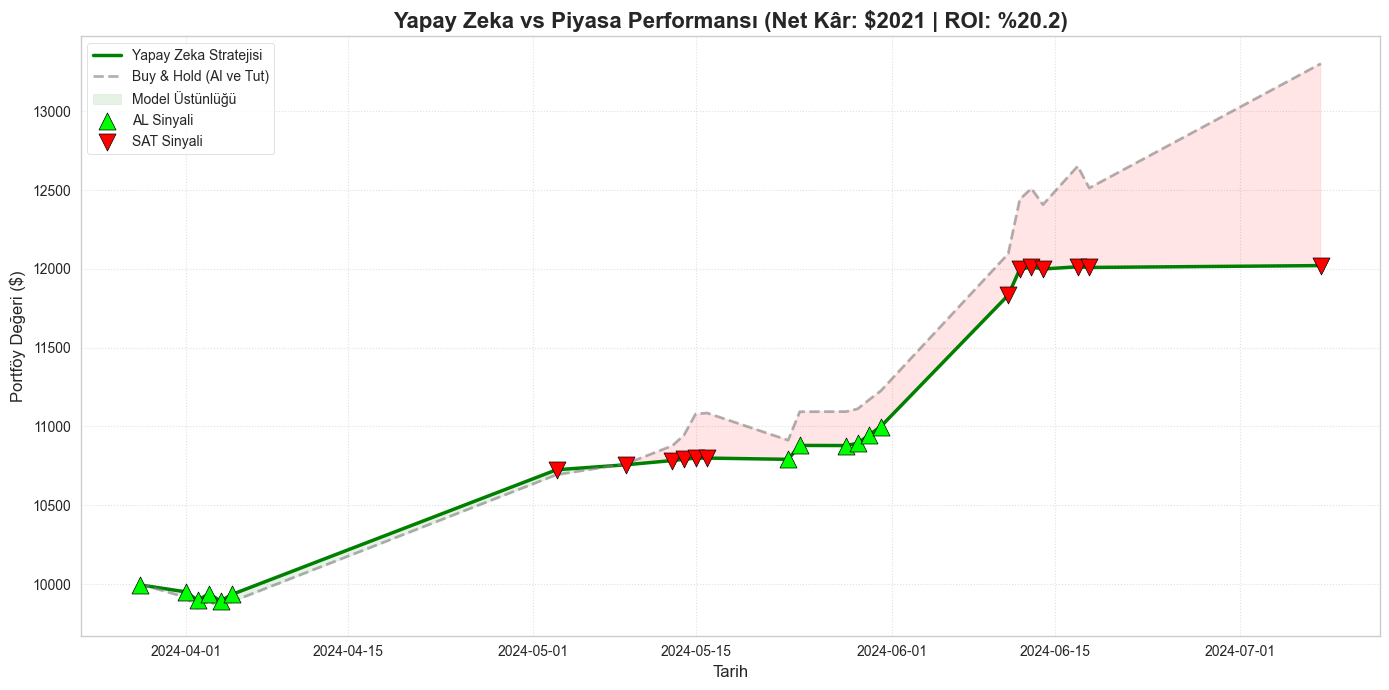

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

df_actions.columns = [col.lower() for col in df_actions.columns]

# Başlangıç sermayesi (Backtest'teki ile aynı olmalı)
initial_capital = 10000.0 

# İlk işlem günündeki fiyatı alalım
first_price = df_actions['price'].iloc[0]
shares_buy_hold = initial_capital / first_price

df_actions['buy_hold_value'] = df_actions['price'] * shares_buy_hold

print("✅ 'buy_hold_value' sütunu başarıyla oluşturuldu.")

# --- 2. GRAFİK ÇİZİMİ ---
plt.figure(figsize=(14, 7))

# Tarihleri formatla
dates = pd.to_datetime(df_actions["date"])
port_vals = df_actions["portfolio_value"]
bh_vals = df_actions["buy_hold_value"]

# A) Model Performansı (Yeşil)
plt.plot(dates, port_vals, label="Yapay Zeka Stratejisi", color='green', linewidth=2.5)

# B) Buy & Hold (Gri)
plt.plot(dates, bh_vals, label="Buy & Hold (Al ve Tut)", color='gray', linestyle='--', linewidth=2, alpha=0.6)

# C) Alanı Boyama (Kâr Farkı)
plt.fill_between(dates, port_vals, bh_vals, where=(port_vals >= bh_vals), 
                 interpolate=True, color='green', alpha=0.1, label="Model Üstünlüğü")
plt.fill_between(dates, port_vals, bh_vals, where=(port_vals < bh_vals), 
                 interpolate=True, color='red', alpha=0.1)

# D) Alım - Satım İşaretleri
buy_signals = df_actions[df_actions['action'] == 'BUY']
sell_signals = df_actions[df_actions['action'] == 'SELL']

if not buy_signals.empty:
    plt.scatter(pd.to_datetime(buy_signals['date']), buy_signals['portfolio_value'], 
                marker='^', color='lime', s=150, edgecolors='black', zorder=5, label='AL Sinyali')

if not sell_signals.empty:
    plt.scatter(pd.to_datetime(sell_signals['date']), sell_signals['portfolio_value'], 
                marker='v', color='red', s=150, edgecolors='black', zorder=5, label='SAT Sinyali')

# Başlık ve Özet
net_profit = port_vals.iloc[-1] - initial_capital
roi = (net_profit / initial_capital) * 100

plt.title(f"Yapay Zeka vs Piyasa Performansı (Net Kâr: ${net_profit:.0f} | ROI: %{roi:.1f})", fontsize=16, fontweight='bold')
plt.xlabel("Tarih", fontsize=12)
plt.ylabel("Portföy Değeri ($)", fontsize=12)
plt.legend(loc="upper left")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

plt.show()

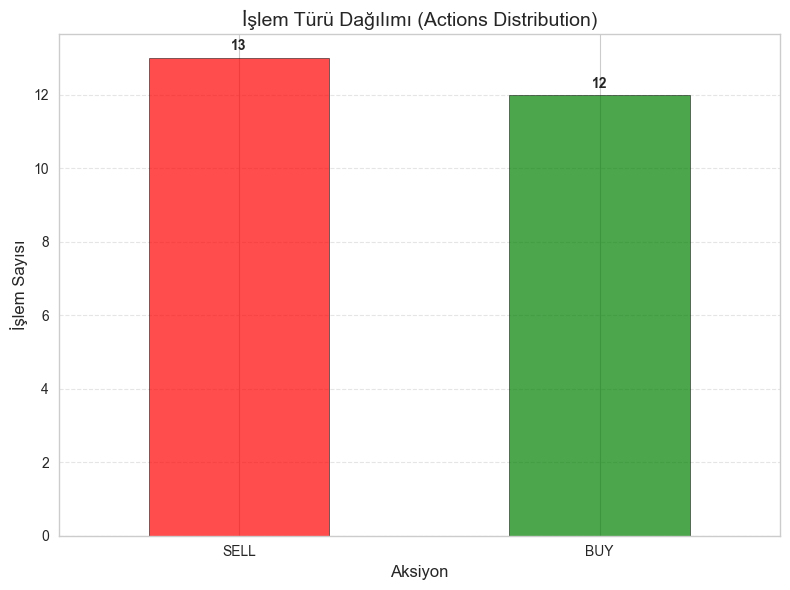

In [39]:
import matplotlib.pyplot as plt

# 1. İşlem Sayılarını Hesapla
# df_actions tablosundaki 'action' sütununu sayar
action_counts = df_actions['action'].value_counts()

# 2. Renkleri Doğru Eşleştirelim
# Pandas sıralamayı değiştirebileceği için renkleri index'e göre atayalım
colors = []
for action in action_counts.index:
    if action == 'BUY':
        colors.append('green')
    elif action == 'SELL':
        colors.append('red')
    else:
        colors.append('blue') # Eğer HOLD varsa Mavi olsun

# 3. Grafiği Çiz
plt.figure(figsize=(8, 6))

# Barları çiz
ax = action_counts.plot(kind='bar', color=colors, alpha=0.7, edgecolor='black', rot=0)

plt.title('İşlem Türü Dağılımı (Actions Distribution)', fontsize=14)
plt.xlabel('Aksiyon', fontsize=12)
plt.ylabel('İşlem Sayısı', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 4. Barların Üzerine Sayıları Yazdır (Annotation)
for i, v in enumerate(action_counts):
    ax.text(i, v + (v*0.01), str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
!pip install sqlalchemy psycopg2-binary


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import pandas as pd
from sqlalchemy import create_engine

# --- 1. POSTGRESQL KAYIT FONKSİYONU ---
def write_predictions_to_postgresql(df, table_name, connection_string):
    """
    DataFrame'i PostgreSQL veritabanına yazar.
    """
    print(f"--- '{table_name}' Tablosuna Yazılıyor ---")
    
    try:
        # Veritabanı motorunu oluştur
        engine = create_engine(connection_string)
        
        # Veriyi yaz (if_exists='replace' dersen tabloyu silip yeniden kurar)
        # Eğer verilerin üzerine eklenmesini istersen 'append' yapabilirsin.
        df.to_sql(
            name=table_name,
            con=engine,
            if_exists='replace',  # Dikkat: Eski tabloyu siler, yenisini yazar.
            index=False           # Index sütununu (0,1,2...) veritabanına yazma
        )
        
        print(f"✅ BAŞARILI: Toplam {len(df)} satır veritabanına kaydedildi.")
        
    except Exception as e:
        print("❌ HATA: Veritabanına yazılırken bir sorun oluştu.")
        print(f"Hata Detayı: {e}")

DB_USER = "postgres"      
DB_PASS = "123456"  
DB_HOST = "localhost"      
DB_PORT = "5432"          
DB_NAME = "postgres"      

connection_str = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

write_predictions_to_postgresql(df_actions, 'apple_model_sonuclari', connection_str)

--- 'apple_model_sonuclari' Tablosuna Yazılıyor ---
✅ BAŞARILI: Toplam 25 satır veritabanına kaydedildi.


In [42]:
import pandas as pd
from sqlalchemy import create_engine

# --- 1. AYARLAR (BURASI GÜNCELLENDİ) ---
DB_USER = "postgres"
DB_PASS = "123456"  # <-- Şifreni tekrar gir
DB_HOST = "localhost"
# HATA BURADAYDI: Veritabanı adını pgAdmin'deki isme göre düzelttik
DB_NAME = "stock_data"           

# Bağlantı motorunu kuruyoruz
connection_str = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:5432/{DB_NAME}"
engine = create_engine(connection_str)


try:
    df_to_save = df_actions.copy()
    df_to_save = df_to_save.rename(columns={
        'date': 'trade_date',
        'action': 'trade_action',
        'y_pred': 'predicted_price',
        'portfolio_value': 'final_portfolio_value'
    })

    target_columns = ['trade_date', 'trade_action', 'predicted_price', 'final_portfolio_value']
    df_final = df_to_save[target_columns]
    
    df_final['predicted_price'] = df_final['predicted_price'].fillna(0)

   
    print(f"--- '{DB_NAME}' veritabanına bağlanılıyor ve yazılıyor... ---")
    df_final.to_sql('stock_predictions', con=engine, if_exists='append', index=False)
    
    print(f"✅ BAŞARILI! {len(df_final)} satır veri 'stock_data' veritabanındaki tabloya yüklendi.")

except Exception as e:
    print("❌ Hata:", e)

--- 'stock_data' veritabanına bağlanılıyor ve yazılıyor... ---


C:\Users\canan\AppData\Local\Temp\ipykernel_23948\4057826509.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['predicted_price'] = df_final['predicted_price'].fillna(0)


✅ BAŞARILI! 25 satır veri 'stock_data' veritabanındaki tabloya yüklendi.
